In [1]:
from commons import *
from dataset_loader import load_images, prepare_dataset
from IPython.display import display
import matplotlib.pyplot as plt
import cv2
import pickle
from keras.models import load_model


DOTS_SRC = 'hit-images-final2/dot'
TRACKS_SRC = 'hit-images-final2/line'
WORMS_SRC = 'hit-images-final2/worms'
ARTIFACTS_SRC = 'hit-images-final2/artefact'

DOTS_AC = 'cache/dots_100000.h5'
TRACKS_AC = 'cache/tracks_100000.h5'
WORMS_AC = 'cache/worms_100000.h5'
ARTIFACTS_AC = 'cache/artifacts_100000.h5'

dots_set =  prepare_dataset(load_images(DOTS_SRC))
worms_set =  prepare_dataset(load_images(WORMS_SRC))
tracks_set =  prepare_dataset(load_images(TRACKS_SRC))
artifacts_set =  prepare_dataset(load_images(ARTIFACTS_SRC))

dots_autoencoder = load_model(DOTS_AC)
worms_autoencoder = load_model(WORMS_AC)
tracks_autoencoder = load_model(TRACKS_AC)
artifacts_autoencoder = load_model(ARTIFACTS_AC)

In [2]:
def count_non_black_pixels(image):
    """
    Zwraca liczbę nieczarnych pikseli z obrazka.

    :param image: obrazek.
    :return: liczba nieczarnych pikseli.
    """
    return np.count_nonzero(image)


def compute_errors(image, recon, dm_func, normalize=True):
    """
    Obliczanie błędu.

    :param image: obrazek źródłowy.
    :param recon: rekonstrukcja.
    :param dm_func: funkcja porównująca, jako parametr przyjmuje (image, recon), zwraca skalar będący miarą podobieństwa.
    :param normalize: jeśli true, to dzieli wynik dm_func przez liczbę nieczarnych pikseli z image.
    :return: tablica
    """
    return dm_func(image, recon, normalize)


def prepare_for_histogram(images, reconstructions, dm_func, normalize=True):
    errors = []
    for (image, recon) in zip(images, reconstructions):
        try:
            mse = compute_errors(image, recon, dm_func, normalize)
            errors.append(mse)
        except:
            errors.append(0)
    return errors

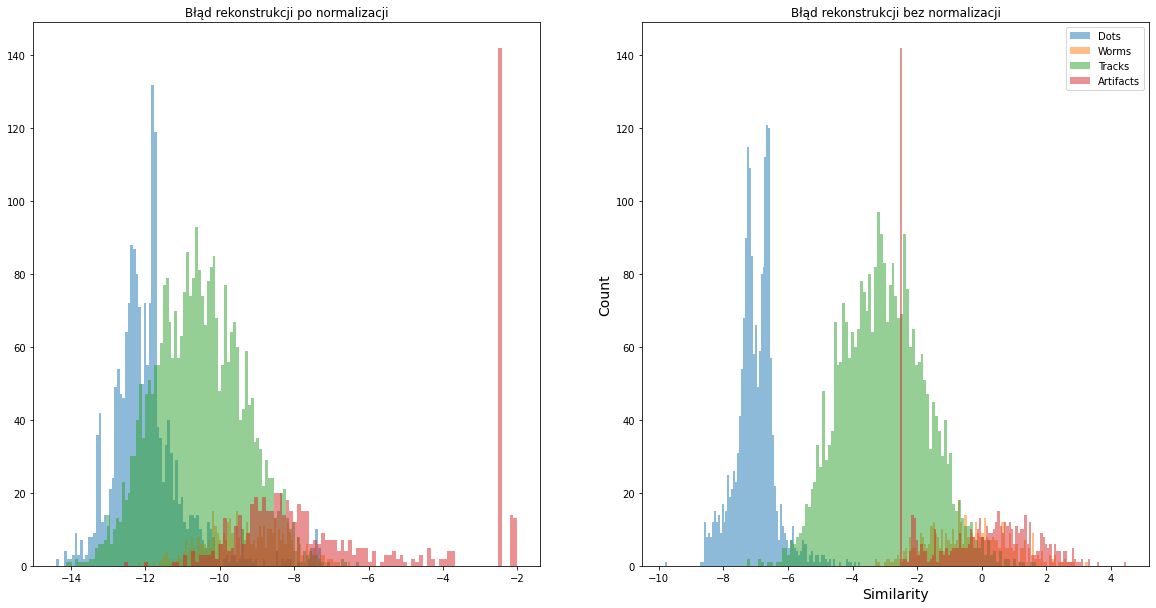

In [4]:
def dm_func_mean2(image, recon, normalize=True):
    blacks = 1
    if normalize:
        blacks = count_non_black_pixels(image)
    if blacks == 0:
        blacks = 1

    err = np.mean((image - recon) ** 2) / (blacks ** 2)
    return math.log2(err * 5000)


dots_reconstruction = dots_autoencoder.predict(dots_set)
worms_reconstruction = worms_autoencoder.predict(worms_set)
tracks_reconstruction = tracks_autoencoder.predict(tracks_set)
artifacts_reconstruction = artifacts_autoencoder.predict(artifacts_set)

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

a0.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Dots')
a0.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Worms')
a0.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Tracks')
a0.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2), bins=100, alpha=0.5, label='Artifacts')
a0.set_title('Błąd rekonstrukcji po normalizacji')

a1.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Dots')
a1.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Worms')
a1.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Tracks')
a1.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, False), bins=100, alpha=0.5, label='Artifacts')
a1.set_title('Błąd rekonstrukcji bez normalizacji')

plt.xlabel("Similarity", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

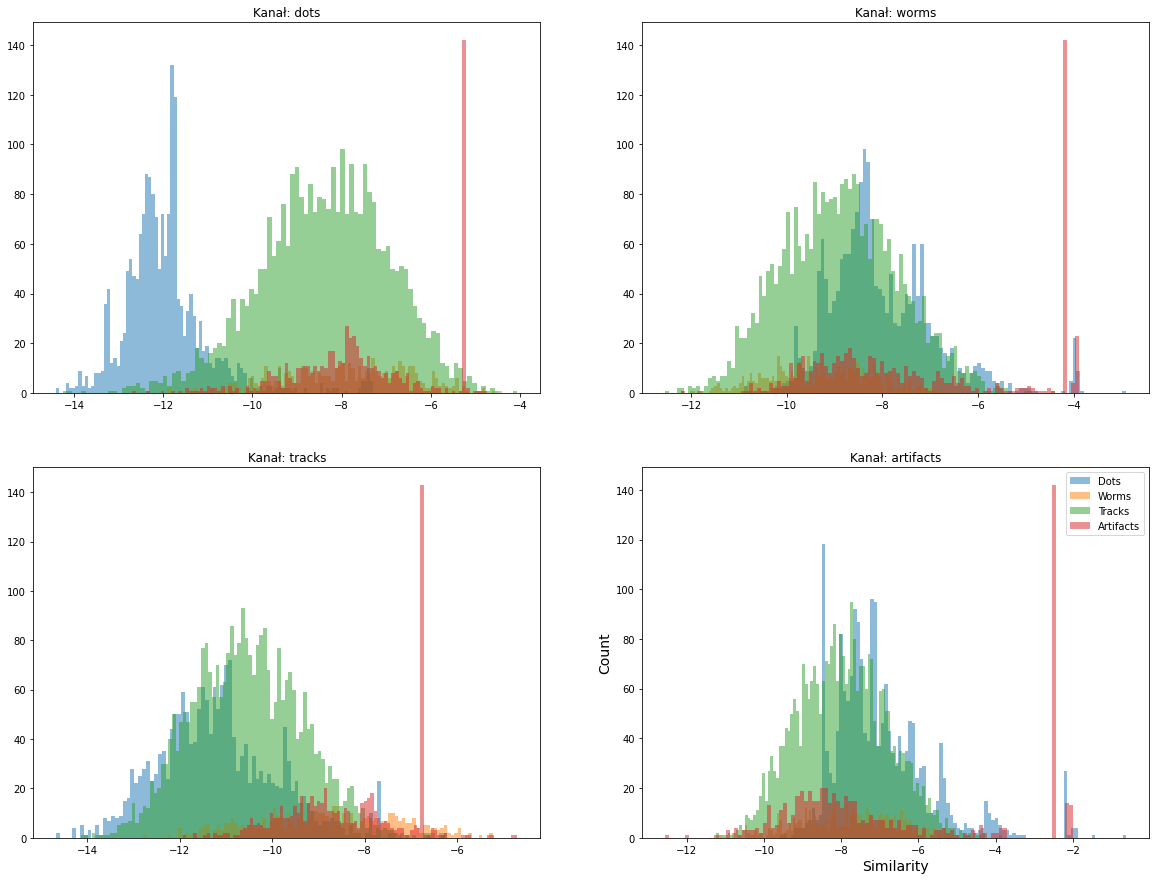

In [7]:
def channel_comparison(autoencoder, axis, title, normalize):
    dots_reconstruction = autoencoder.predict(dots_set)
    worms_reconstruction = autoencoder.predict(worms_set)
    tracks_reconstruction = autoencoder.predict(tracks_set)
    artifacts_reconstruction = autoencoder.predict(artifacts_set)

    axis.hist(prepare_for_histogram(dots_set, dots_reconstruction, dm_func_mean2, normalize), bins=100, alpha=0.5, label='Dots')
    axis.hist(prepare_for_histogram(worms_set, worms_reconstruction, dm_func_mean2, normalize), bins=100, alpha=0.5, label='Worms')
    axis.hist(prepare_for_histogram(tracks_set, tracks_reconstruction, dm_func_mean2, normalize), bins=100, alpha=0.5, label='Tracks')
    axis.hist(prepare_for_histogram(artifacts_set, artifacts_reconstruction, dm_func_mean2, normalize), bins=100, alpha=0.5, label='Artifacts')
    axis.set_title(title)


fig, ((ad, aw), (at, aa)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
channel_comparison(dots_autoencoder, ad, 'Kanał: dots, z normalizacją', True)
channel_comparison(worms_autoencoder, aw, 'Kanał: worms, z normalizacją', True)
channel_comparison(tracks_autoencoder, at, 'Kanał: tracks, z normalizacją', True)
channel_comparison(artifacts_autoencoder, aa, 'Kanał: artifacts, z normalizacją', True)

plt.xlabel("Similarity", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

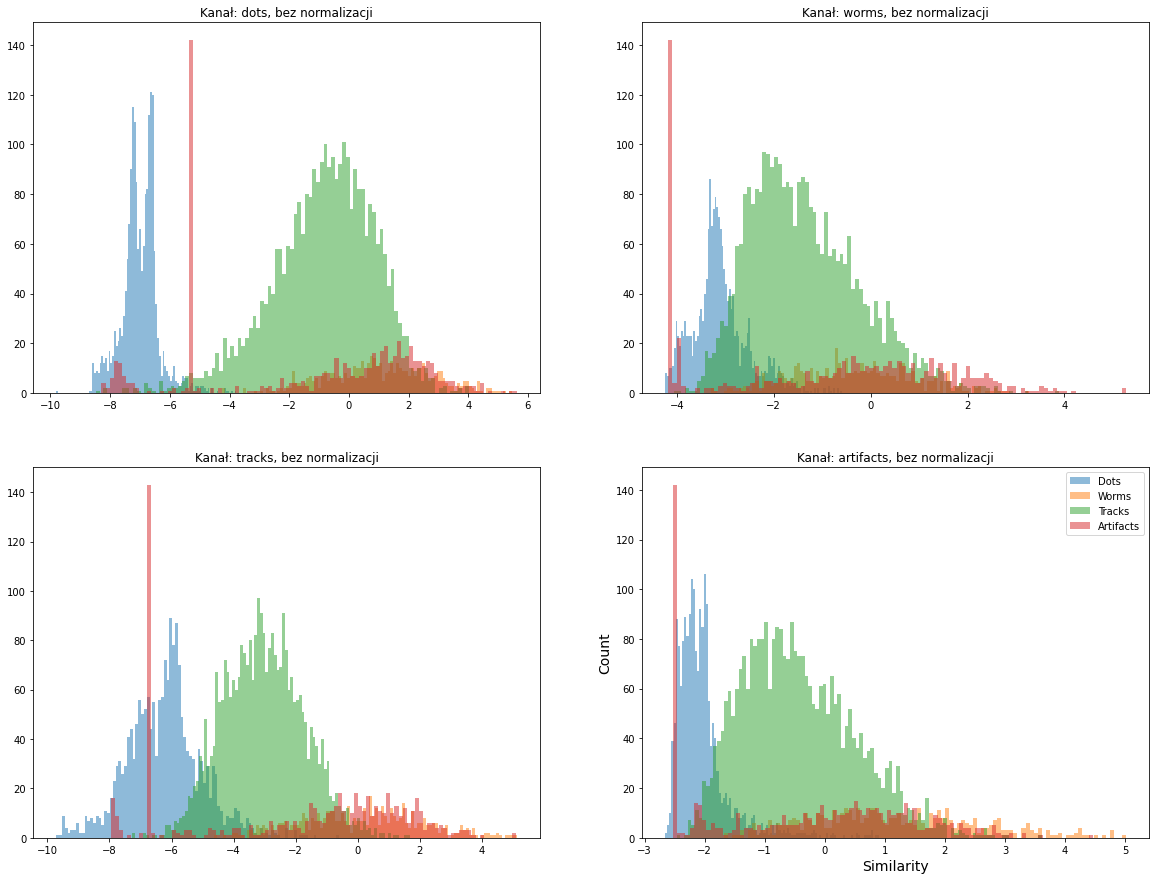

In [8]:
fig, ((ad, aw), (at, aa)) = plt.subplots(nrows=2, ncols=2, figsize=(20,15))
channel_comparison(dots_autoencoder, ad, 'Kanał: dots, bez normalizacji', False)
channel_comparison(worms_autoencoder, aw, 'Kanał: worms, bez normalizacji', False)
channel_comparison(tracks_autoencoder, at, 'Kanał: tracks, bez normalizacji', False)
channel_comparison(artifacts_autoencoder, aa, 'Kanał: artifacts, bez normalizacji', False)

plt.xlabel("Similarity", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')
plt.show()

Kanał dots


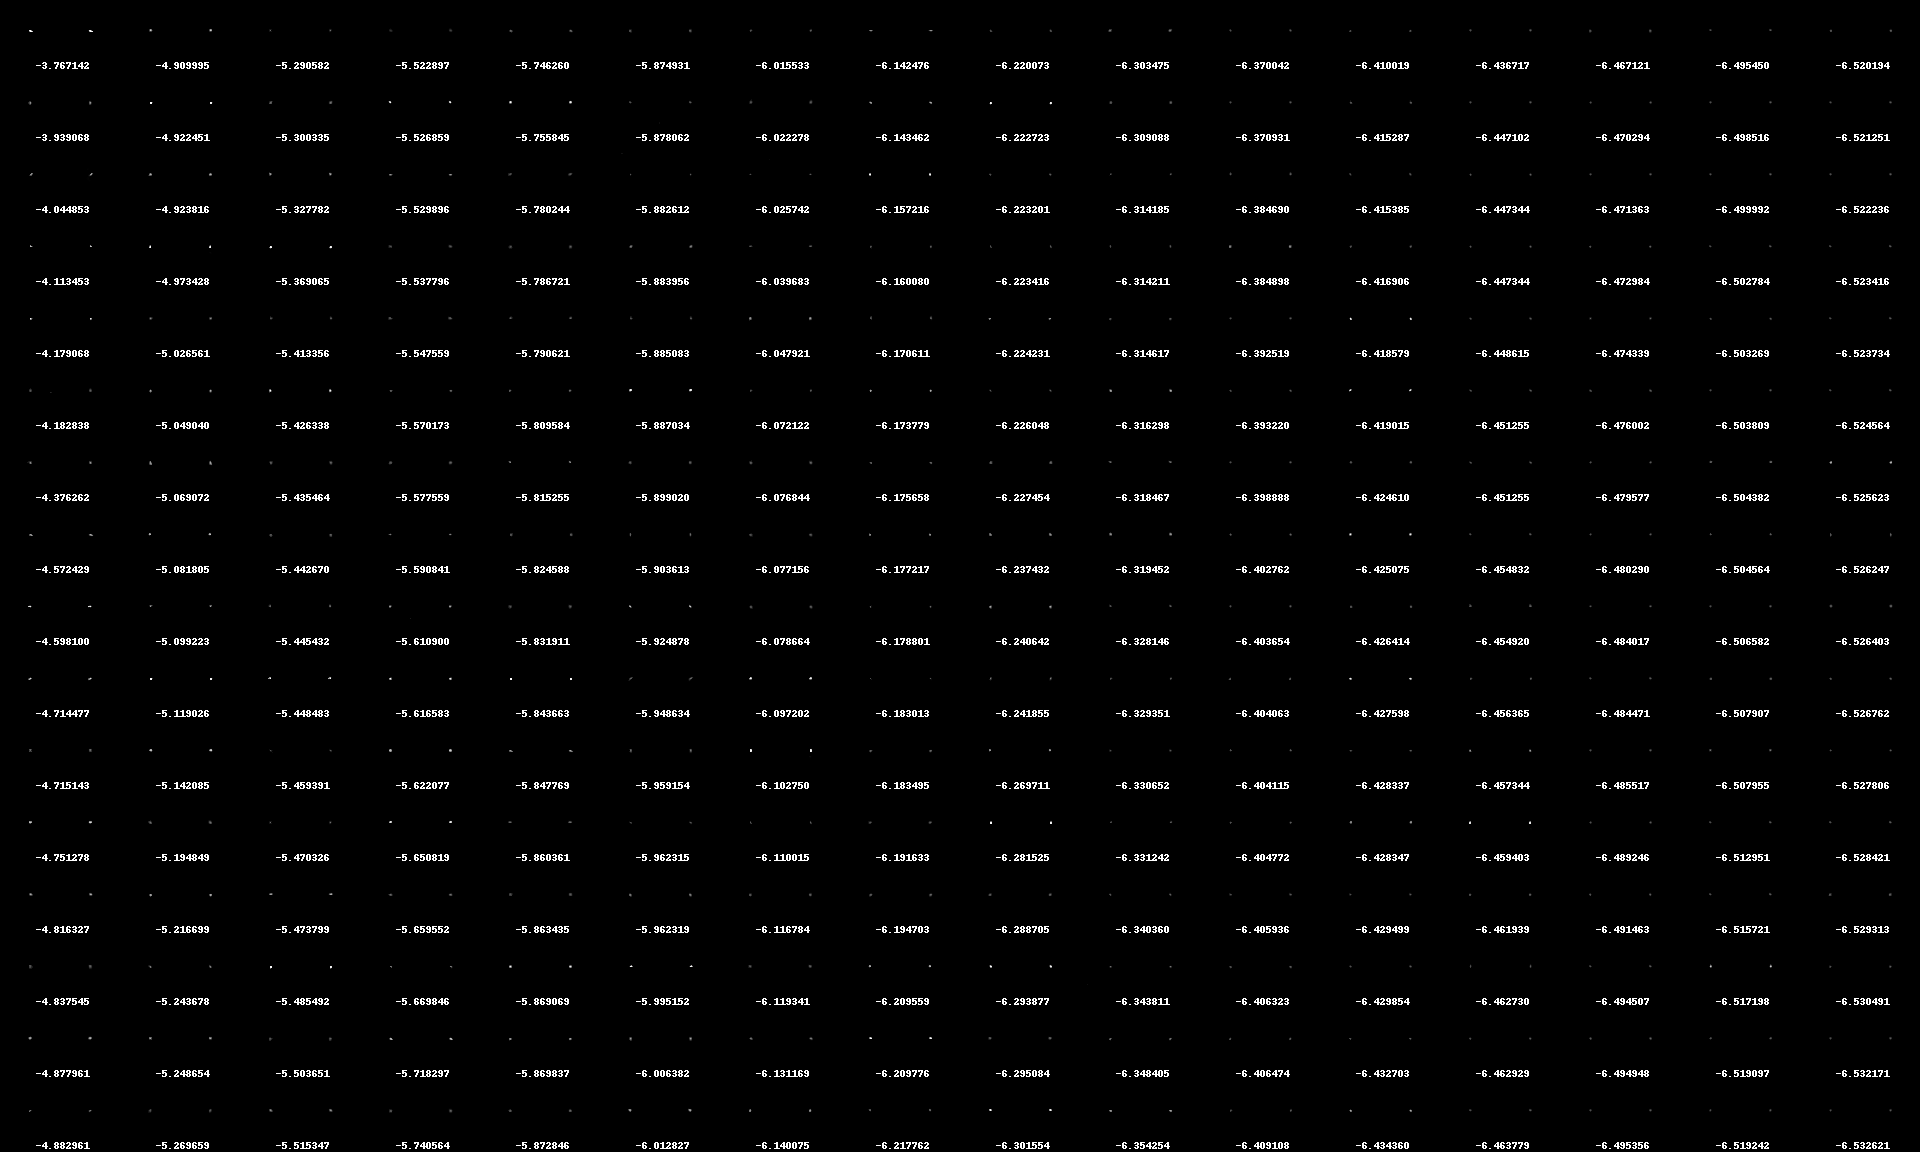

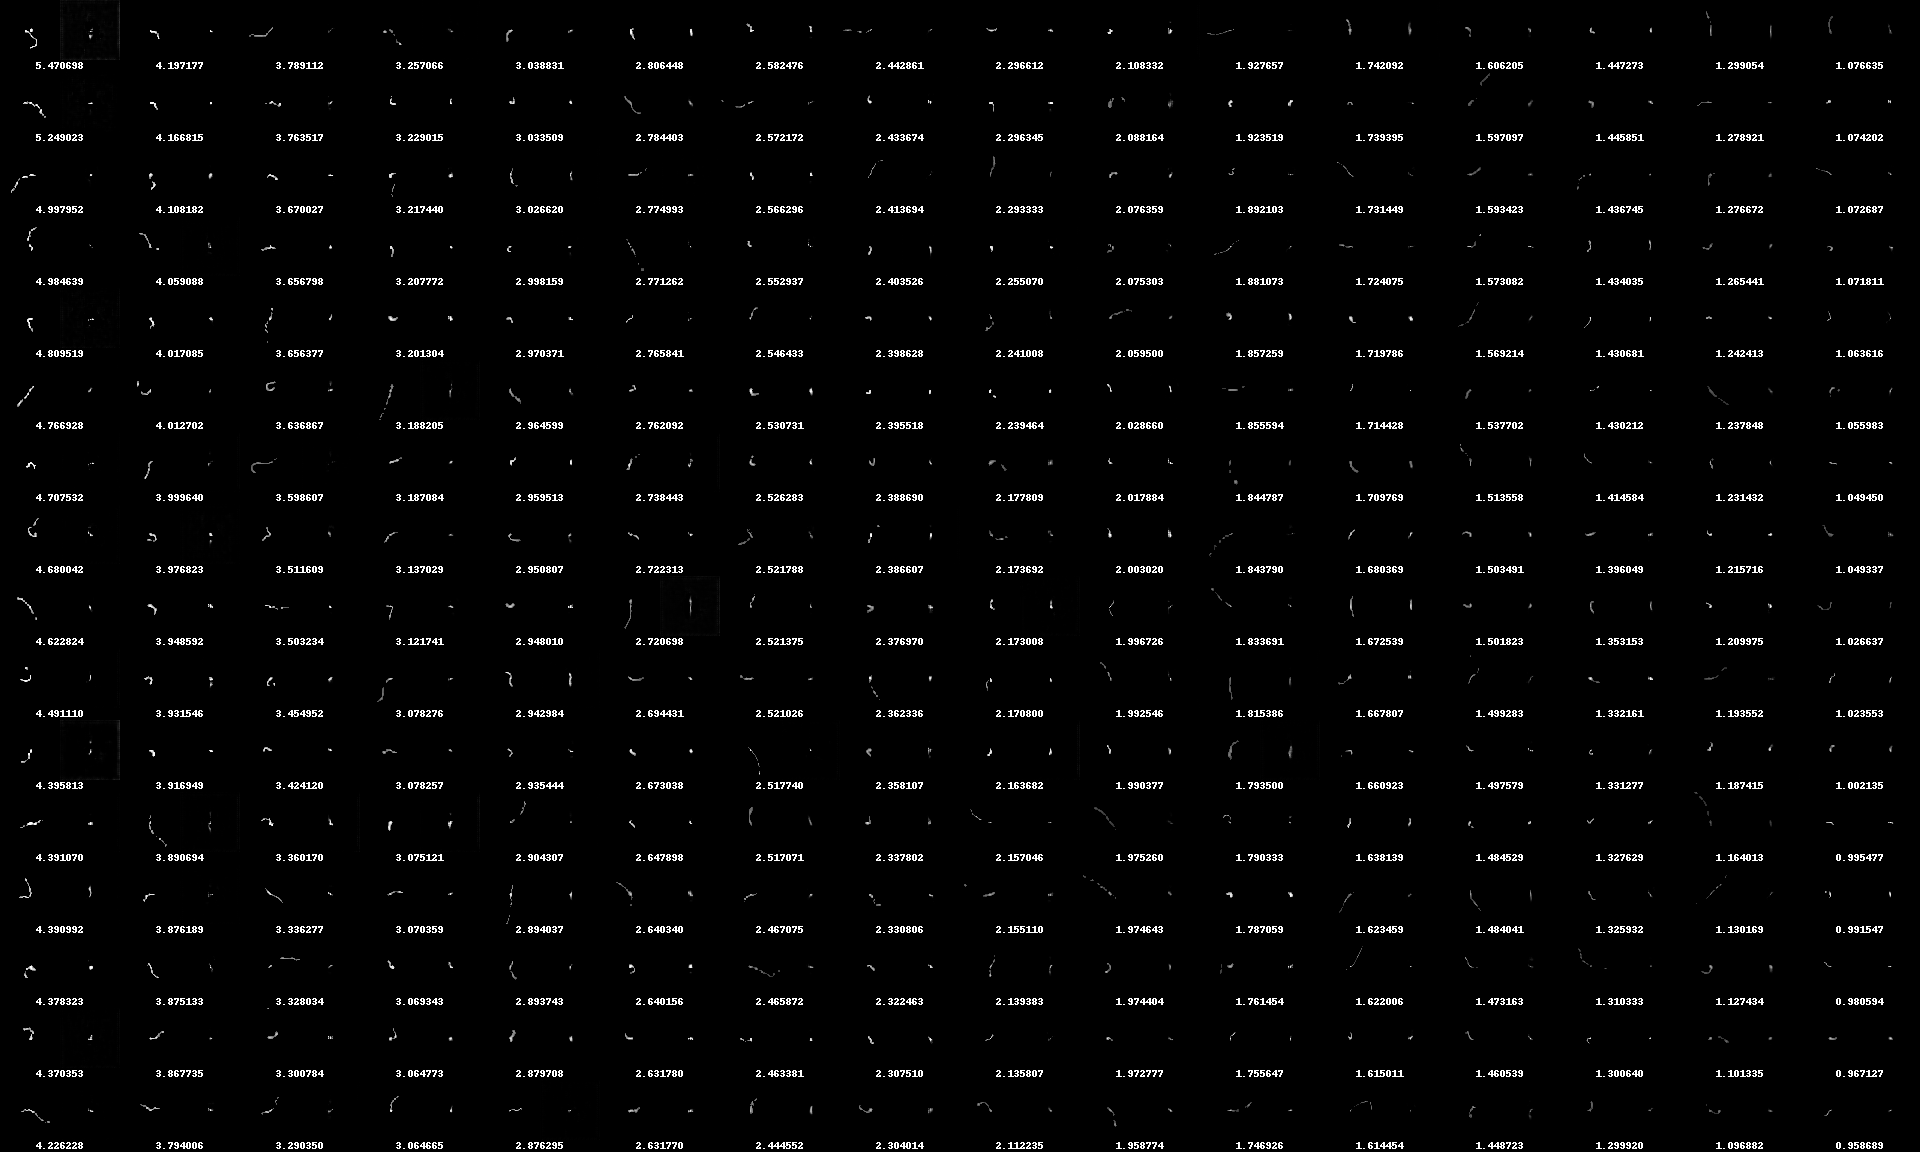

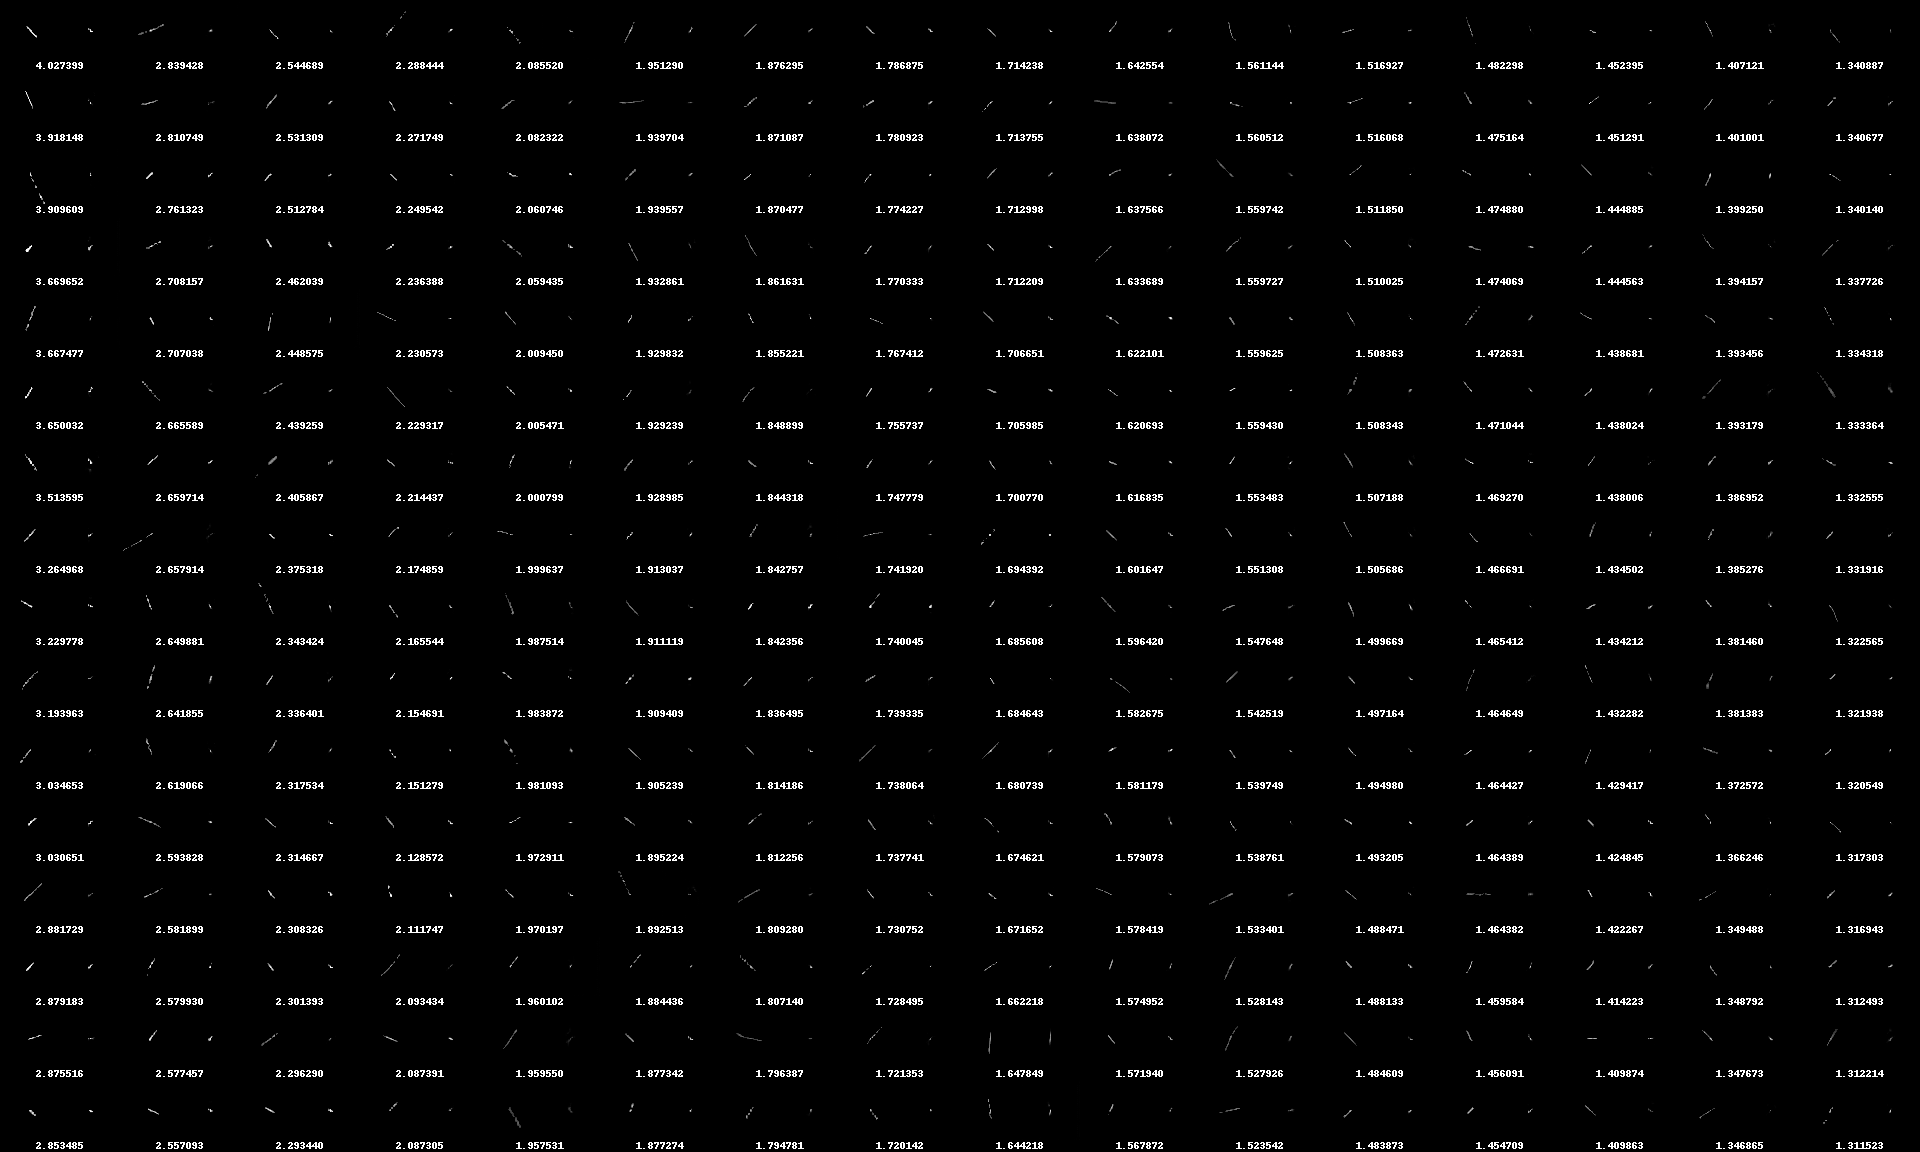

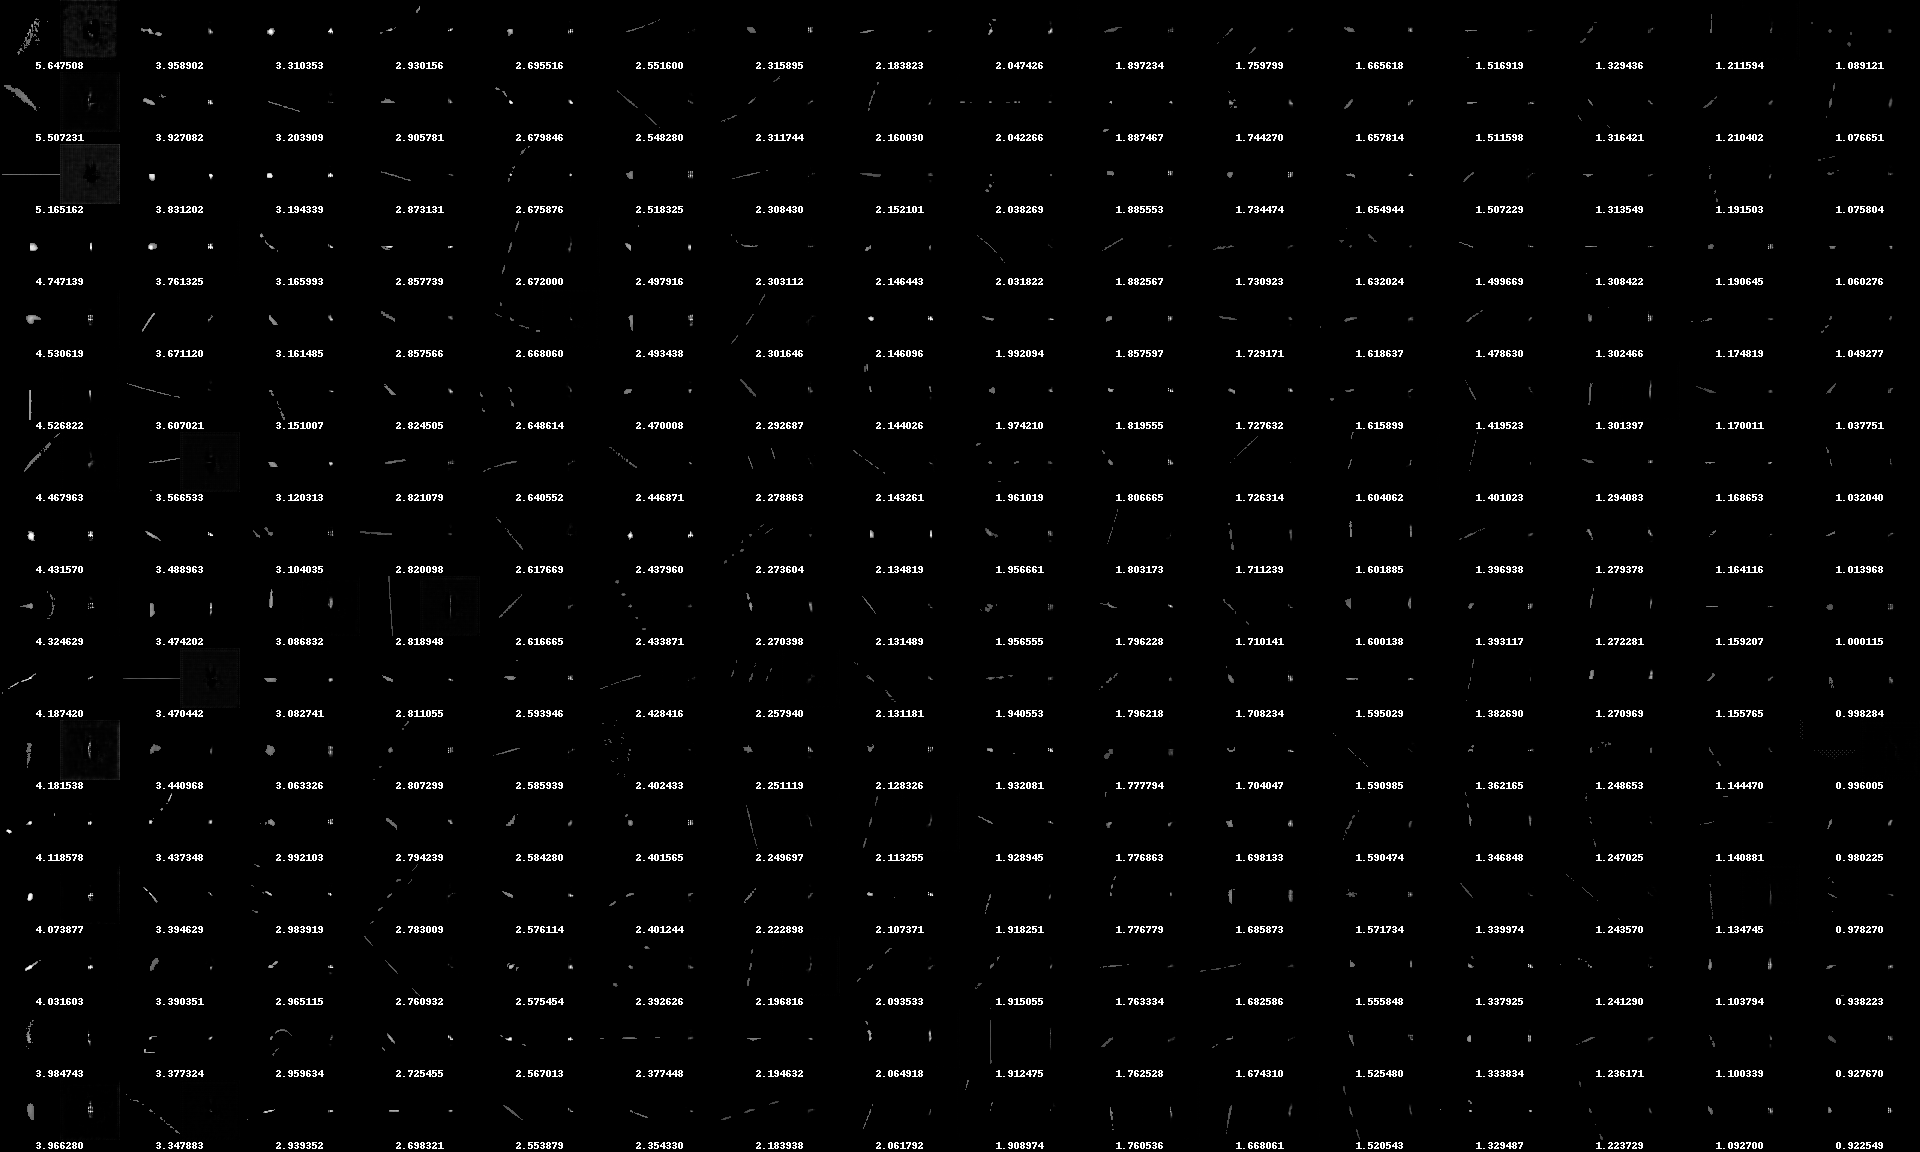

Kanał tracks


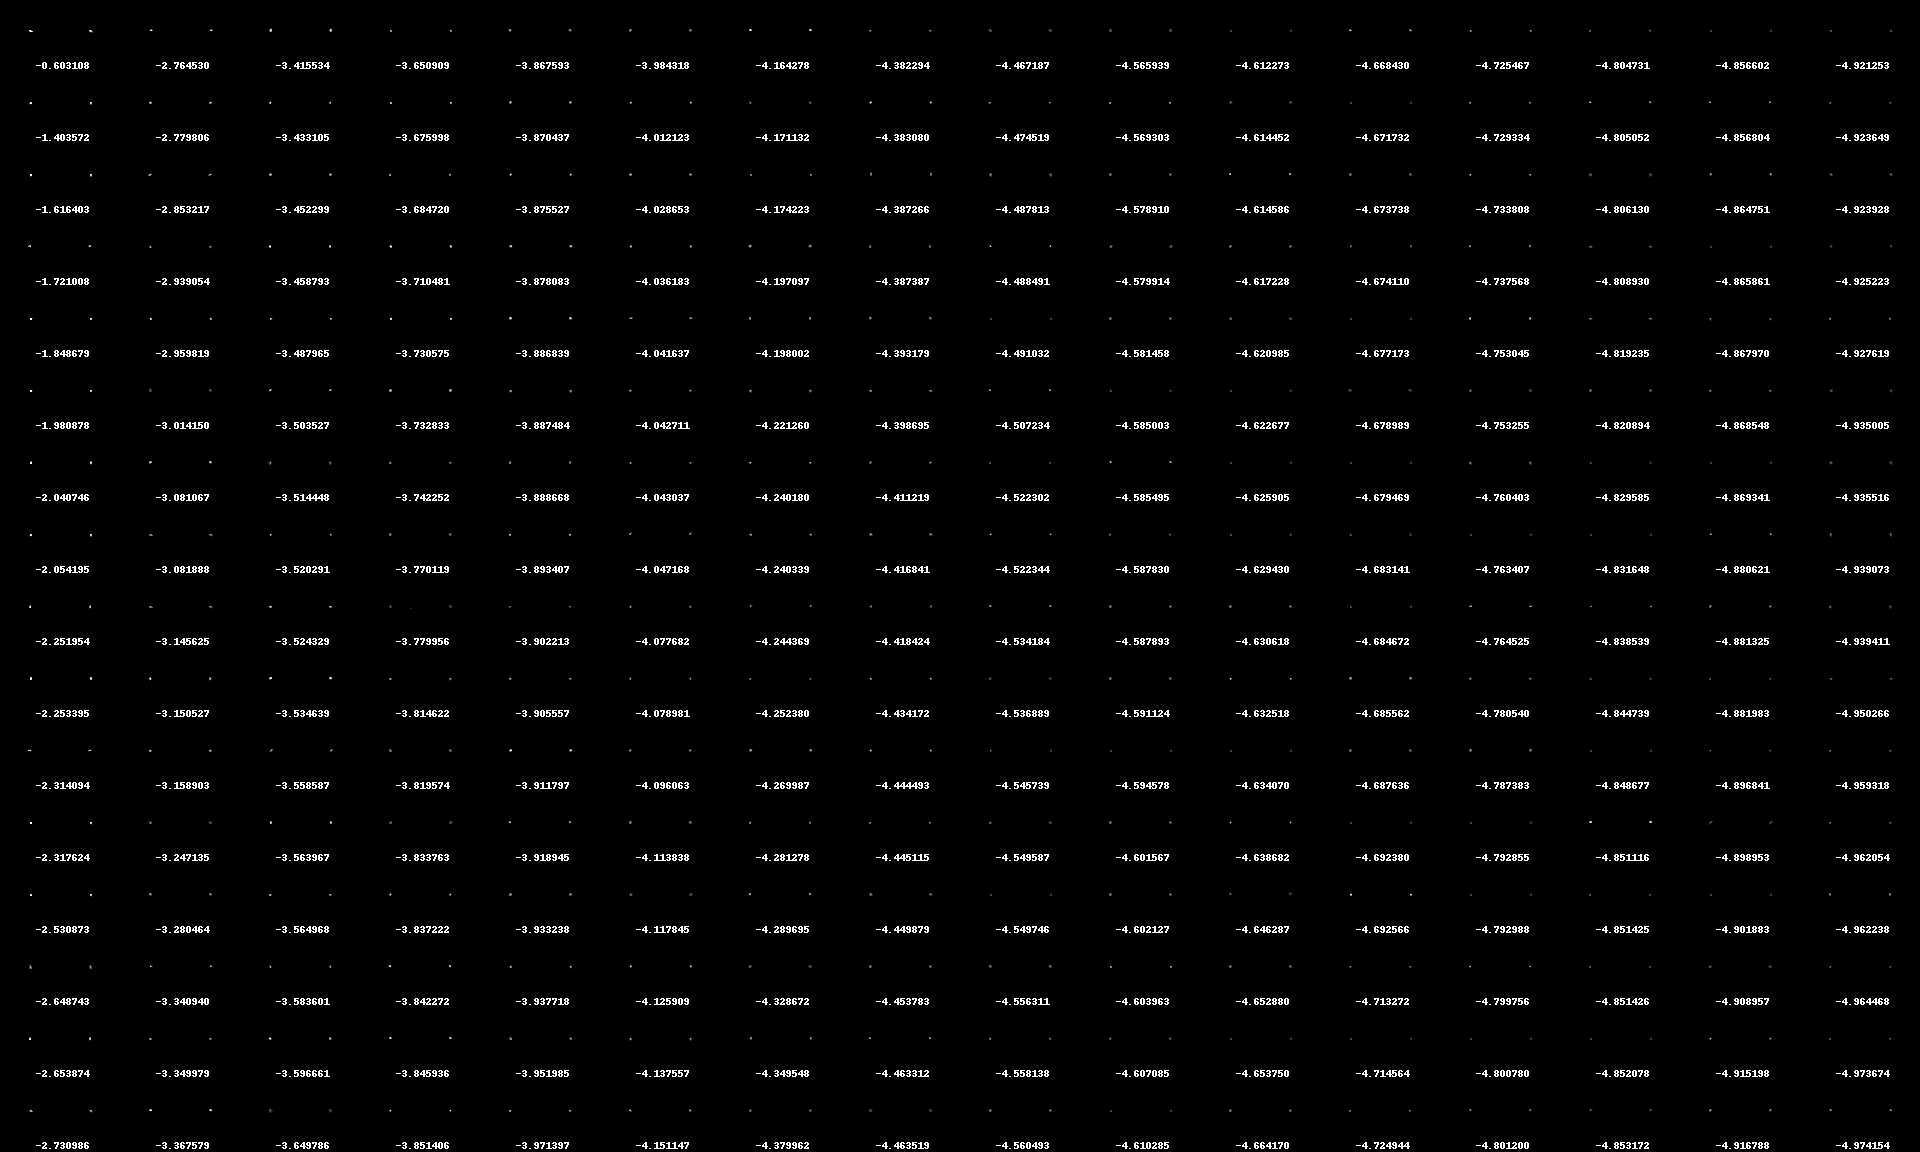

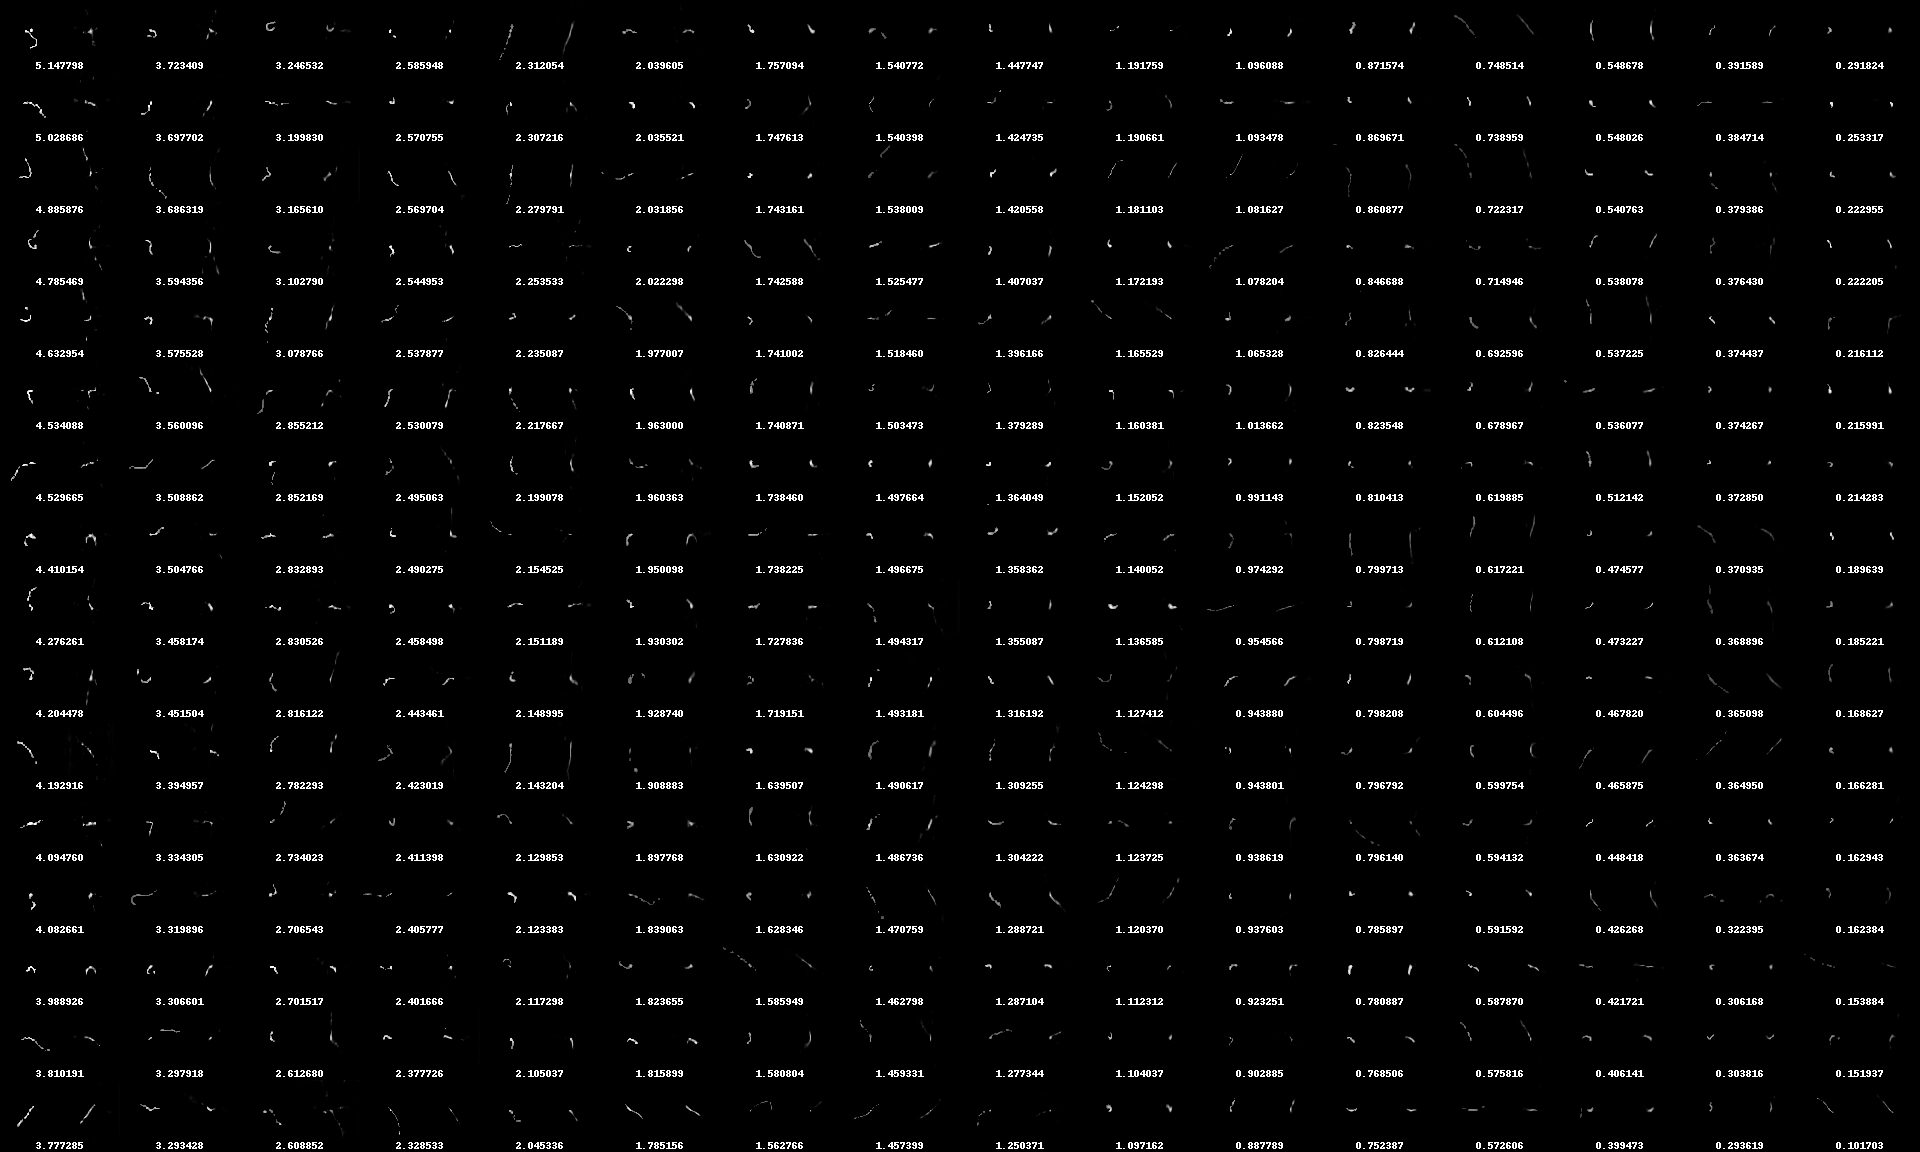

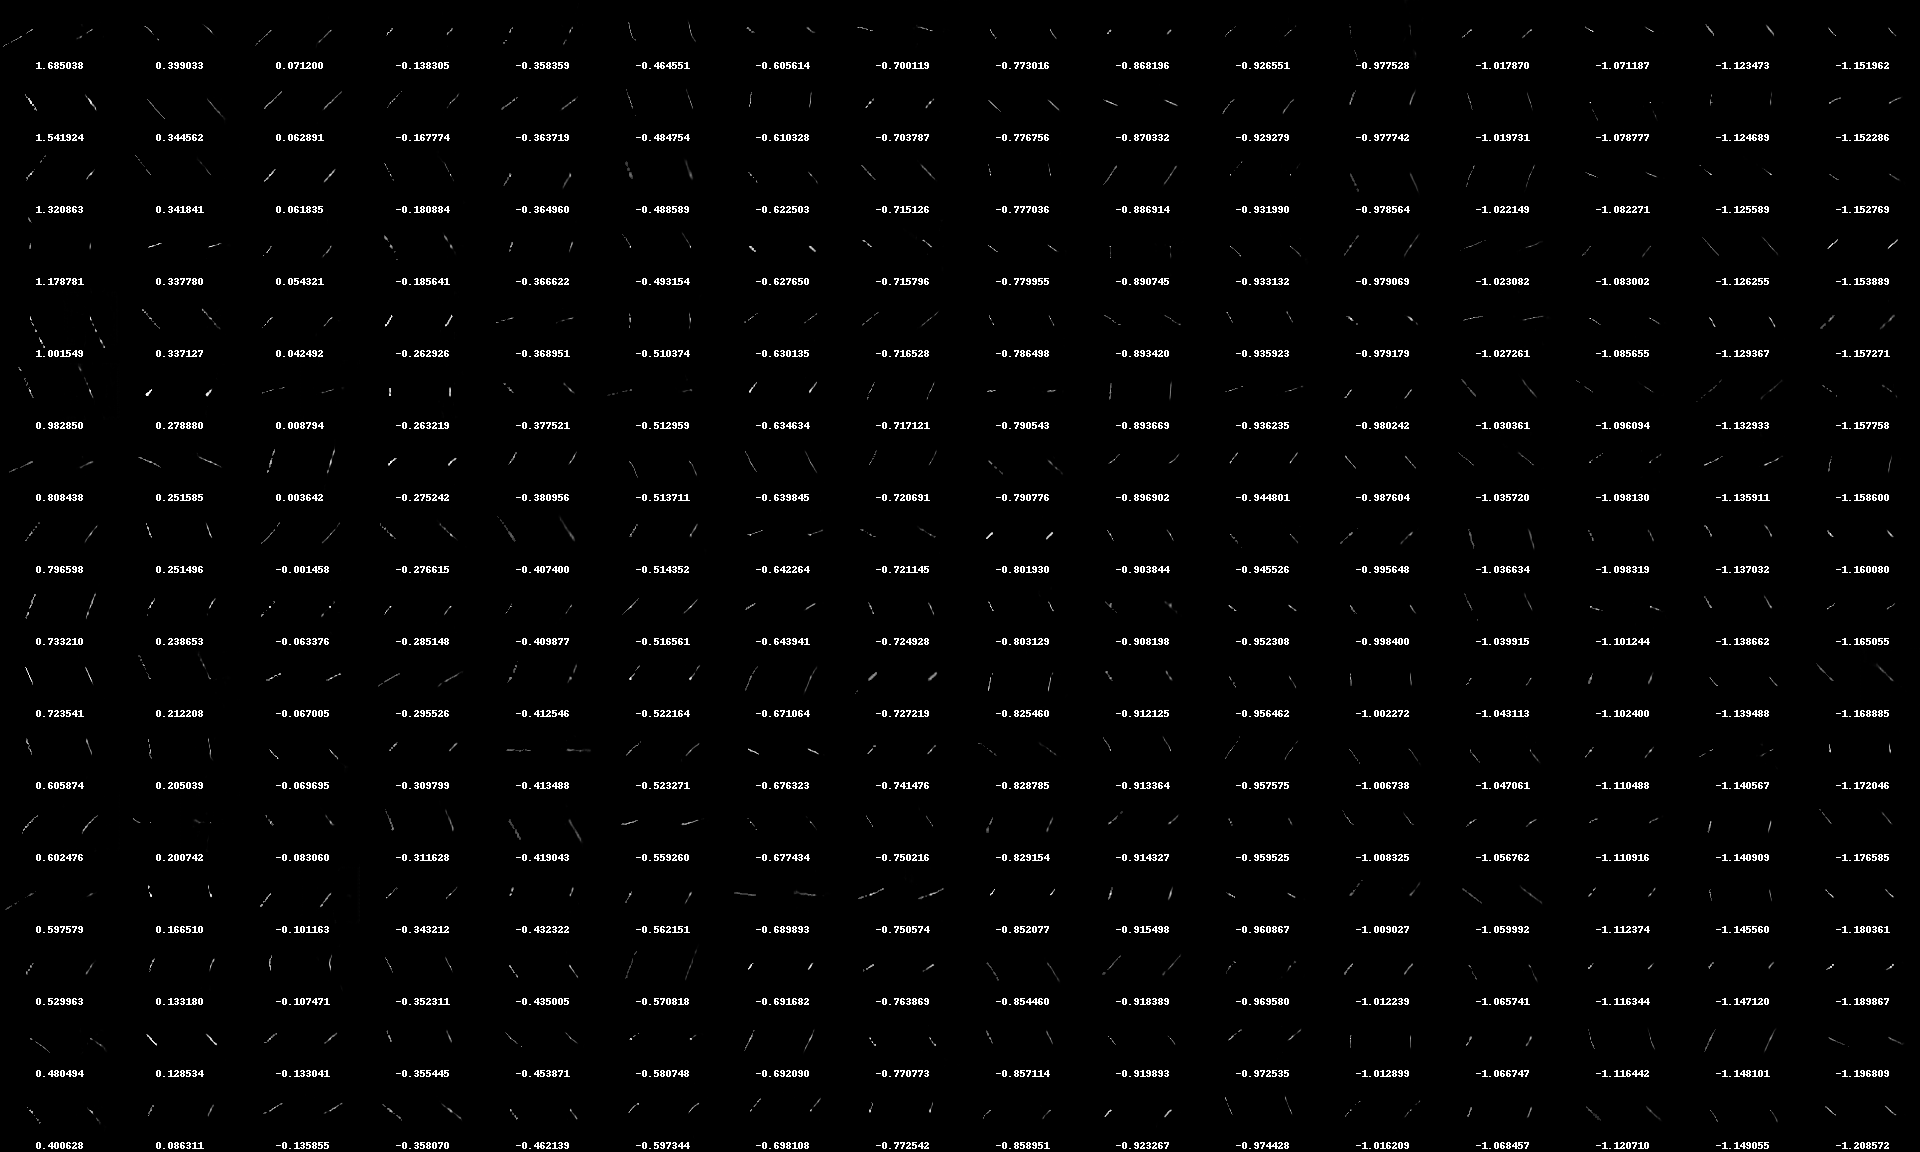

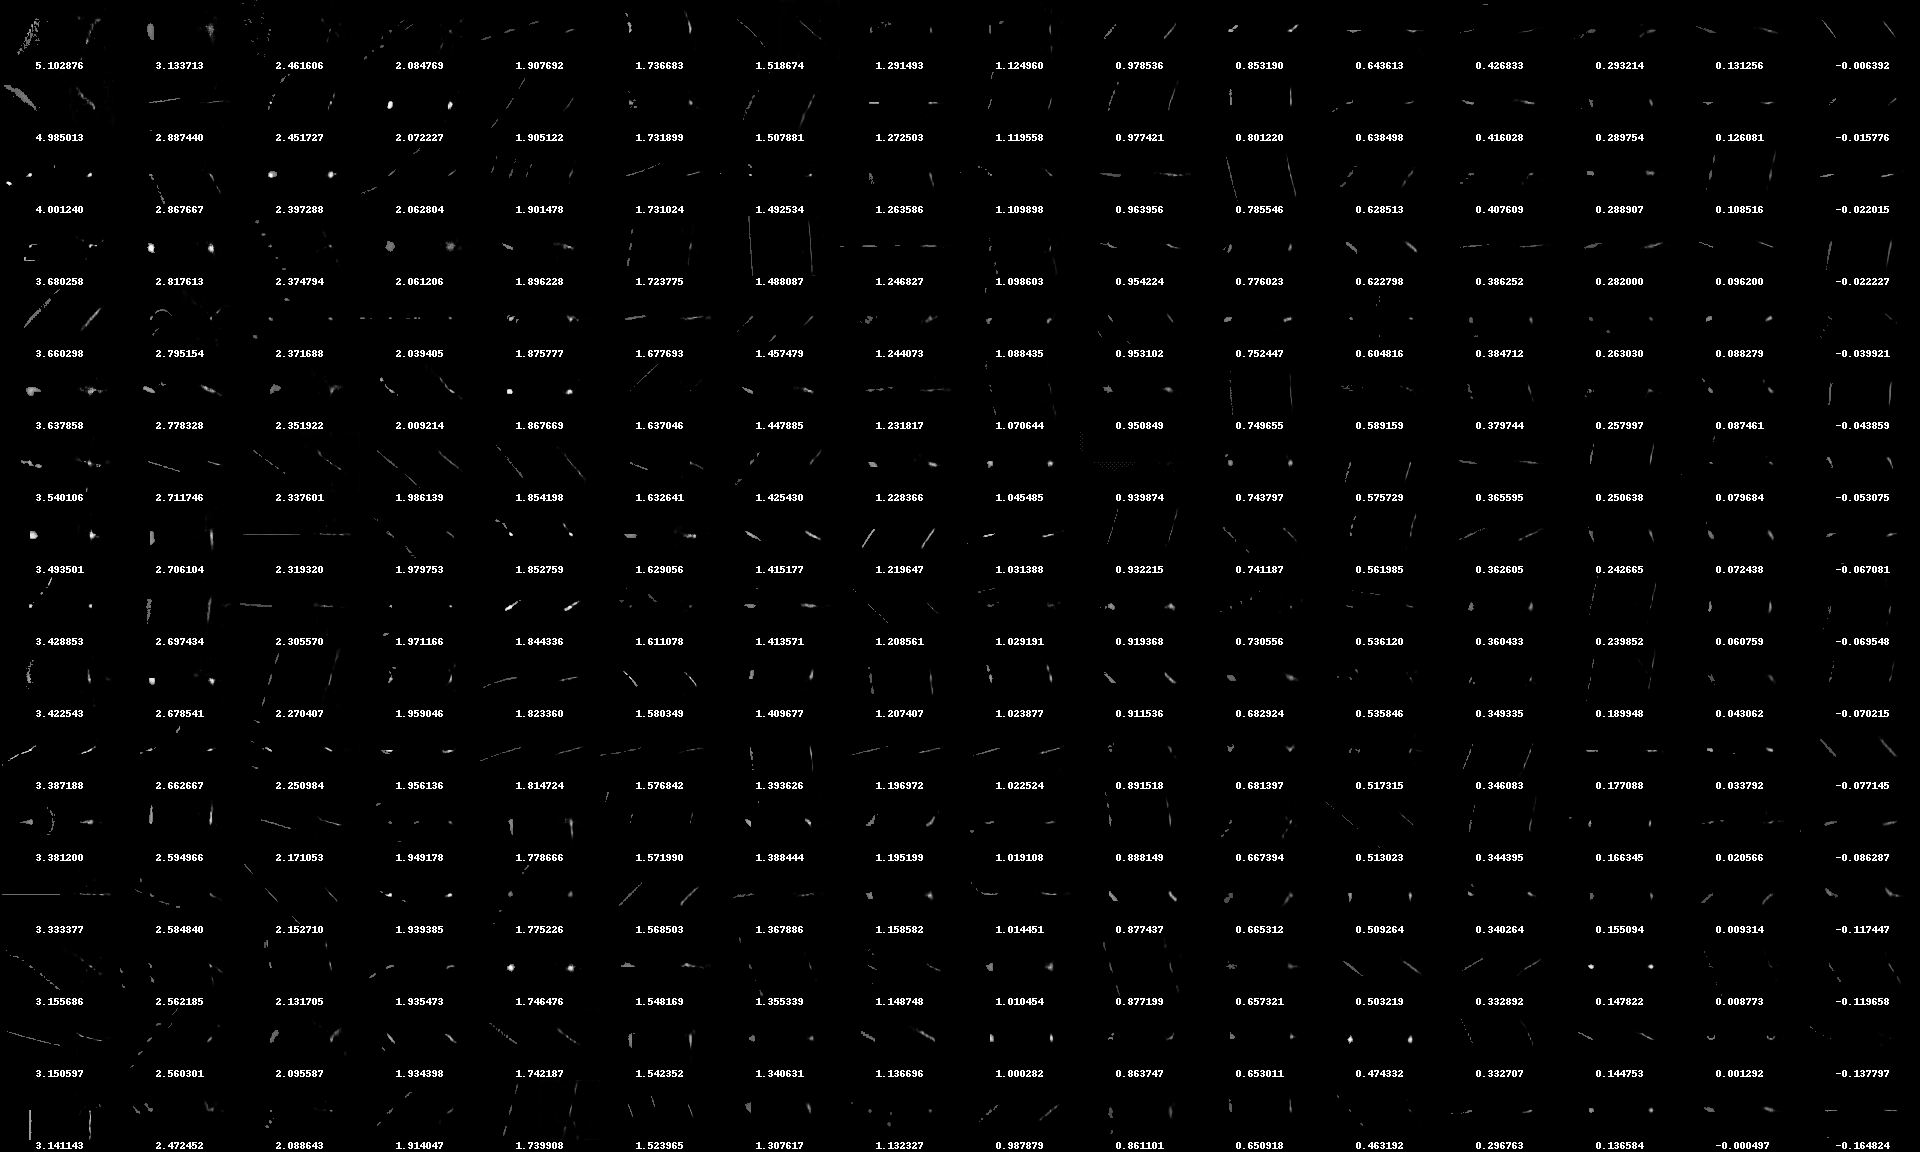

Kanał worms


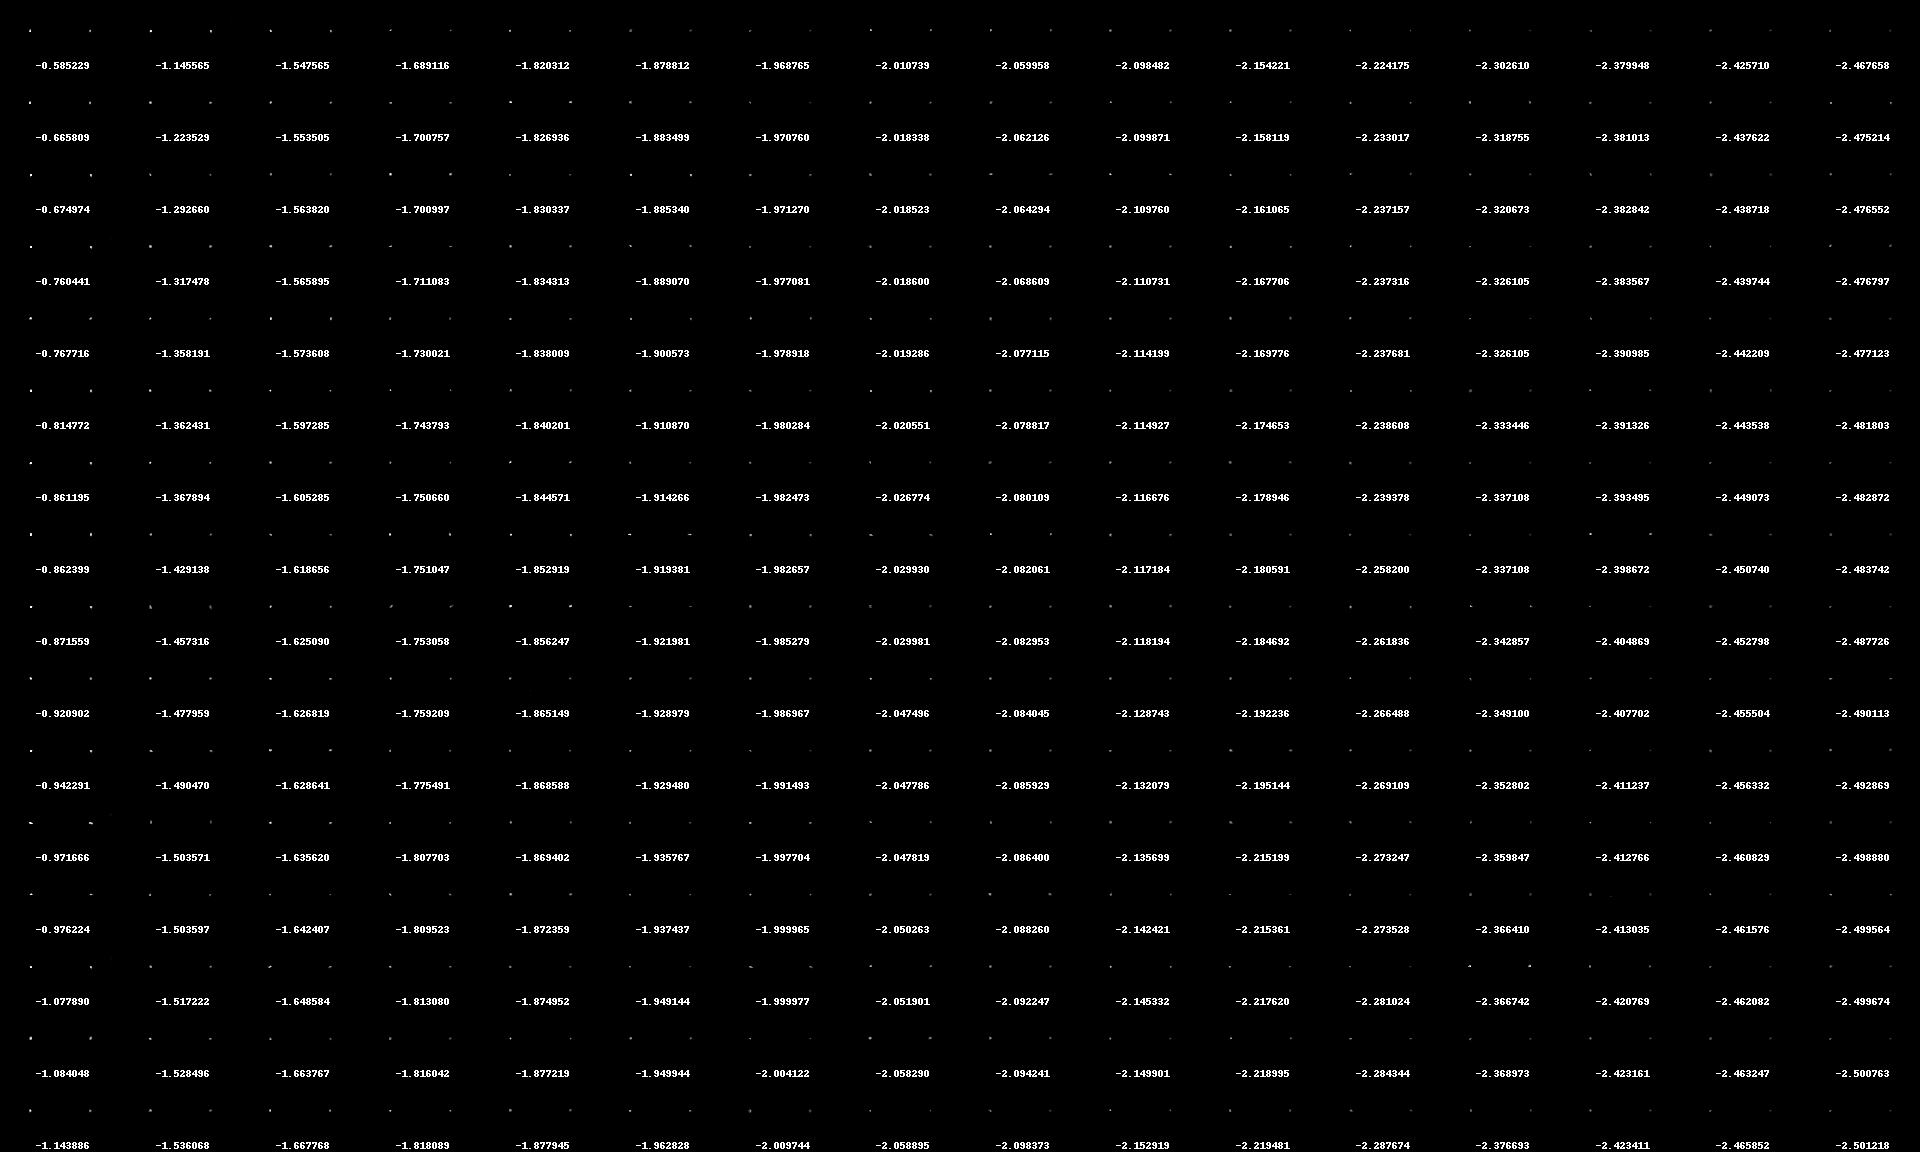

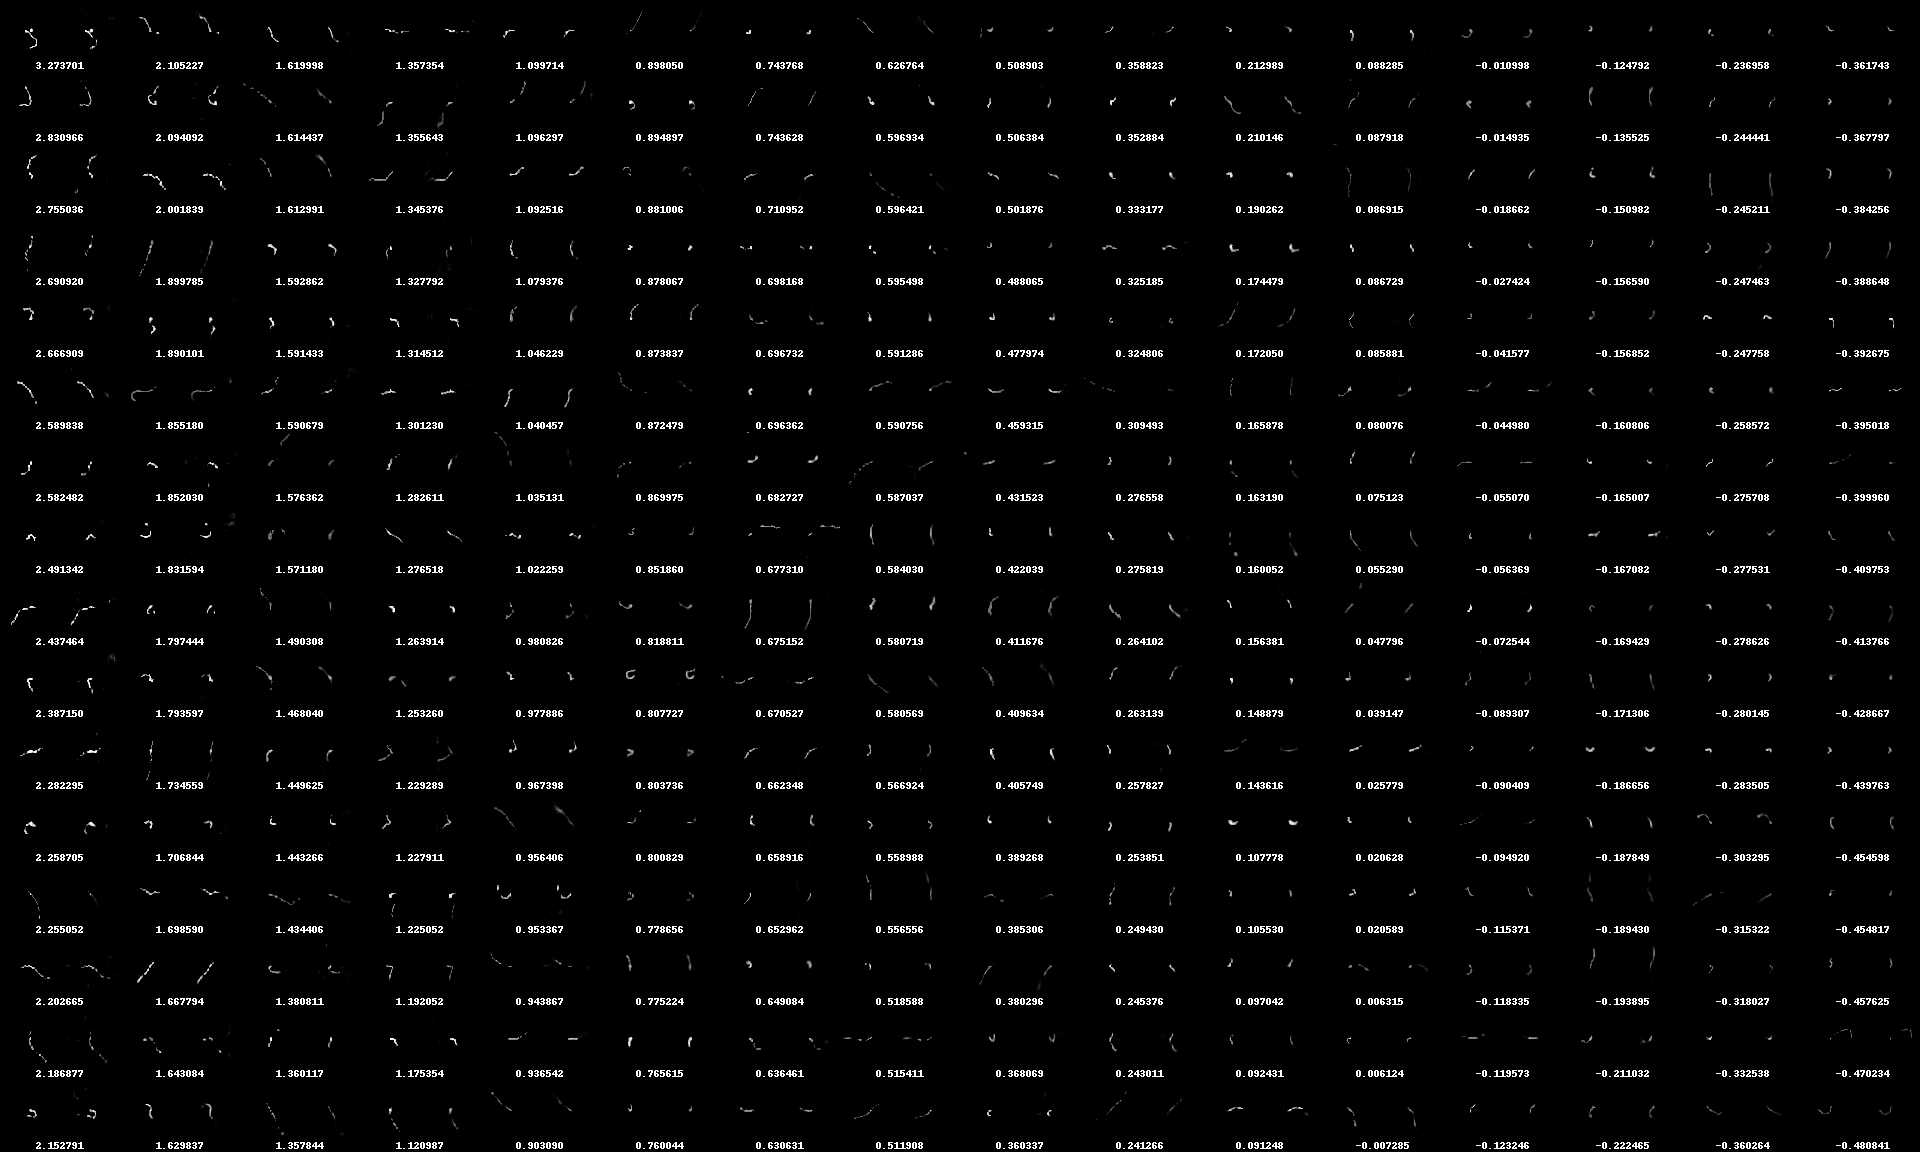

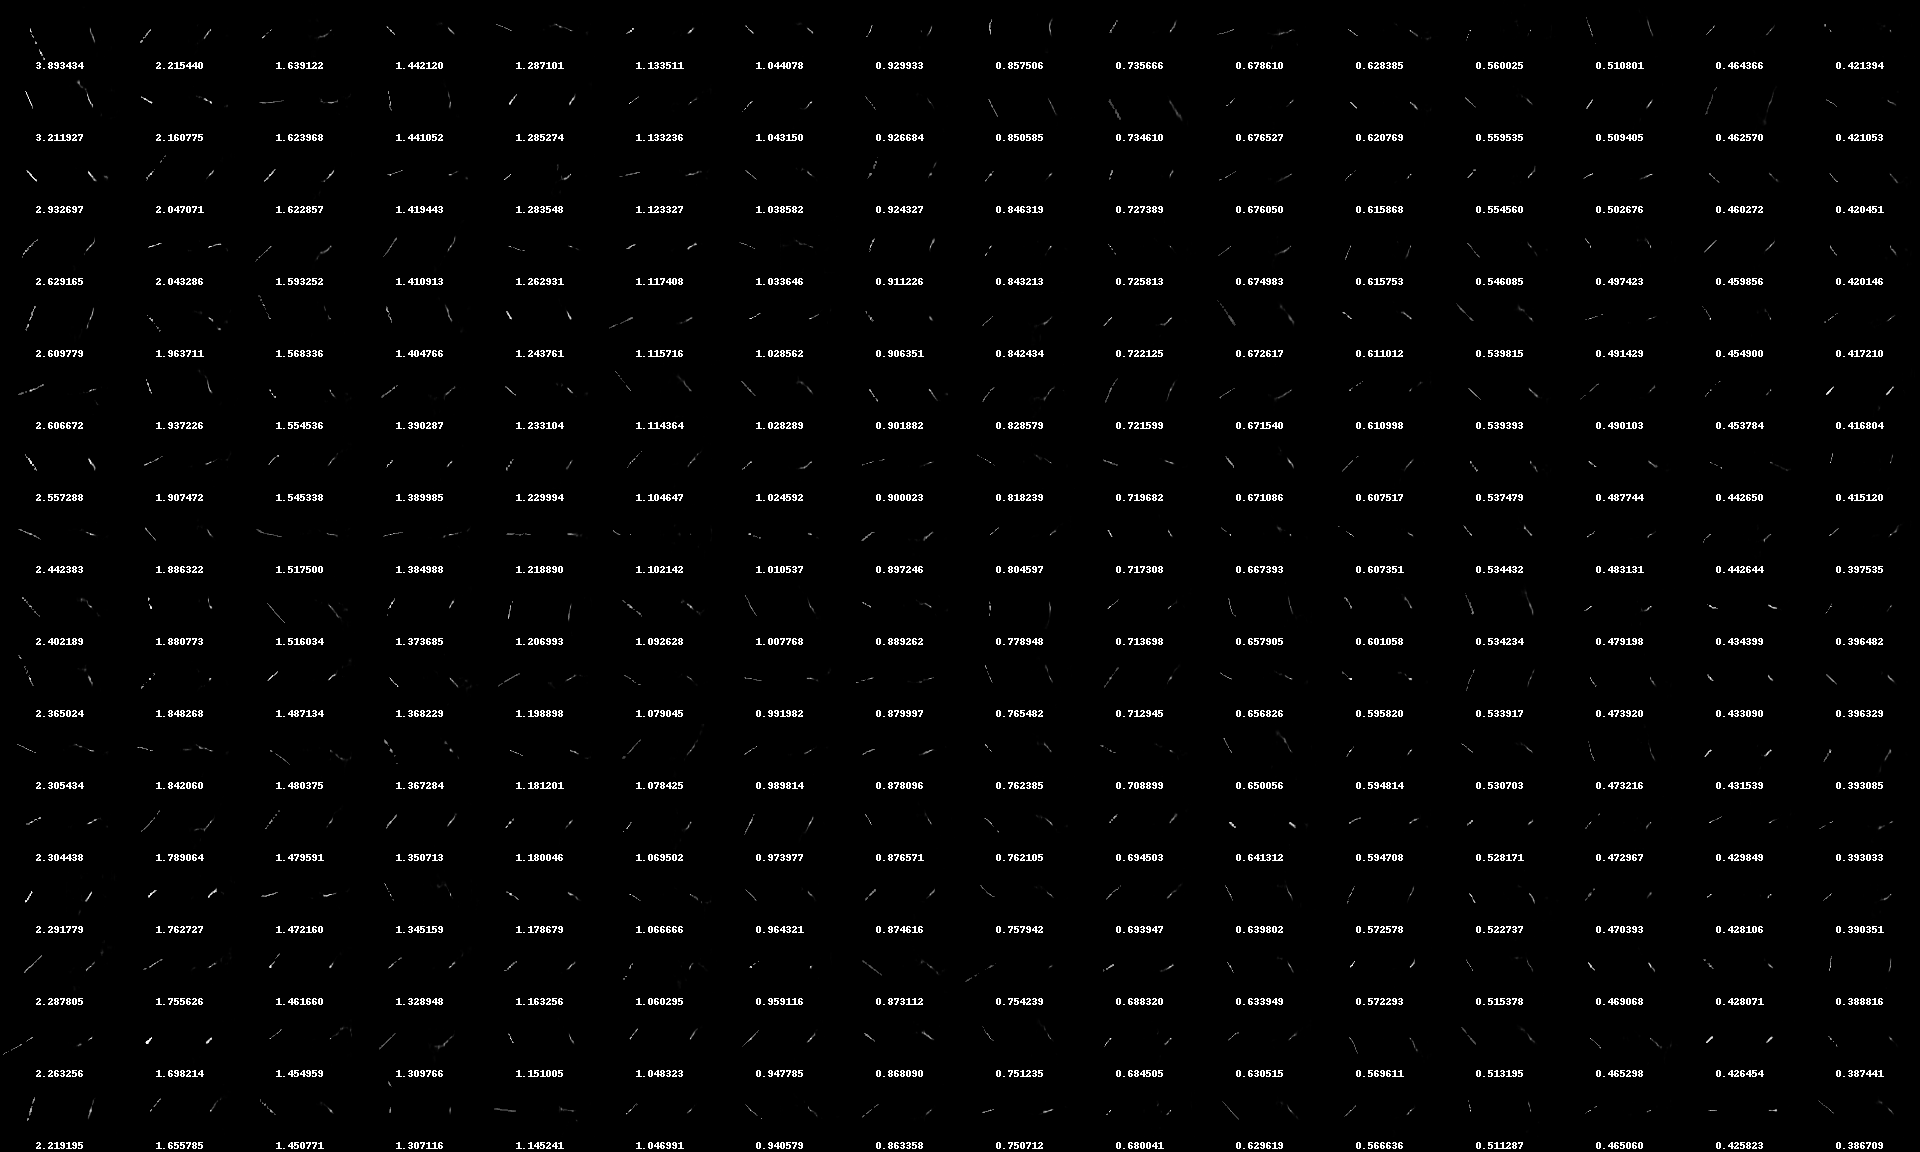

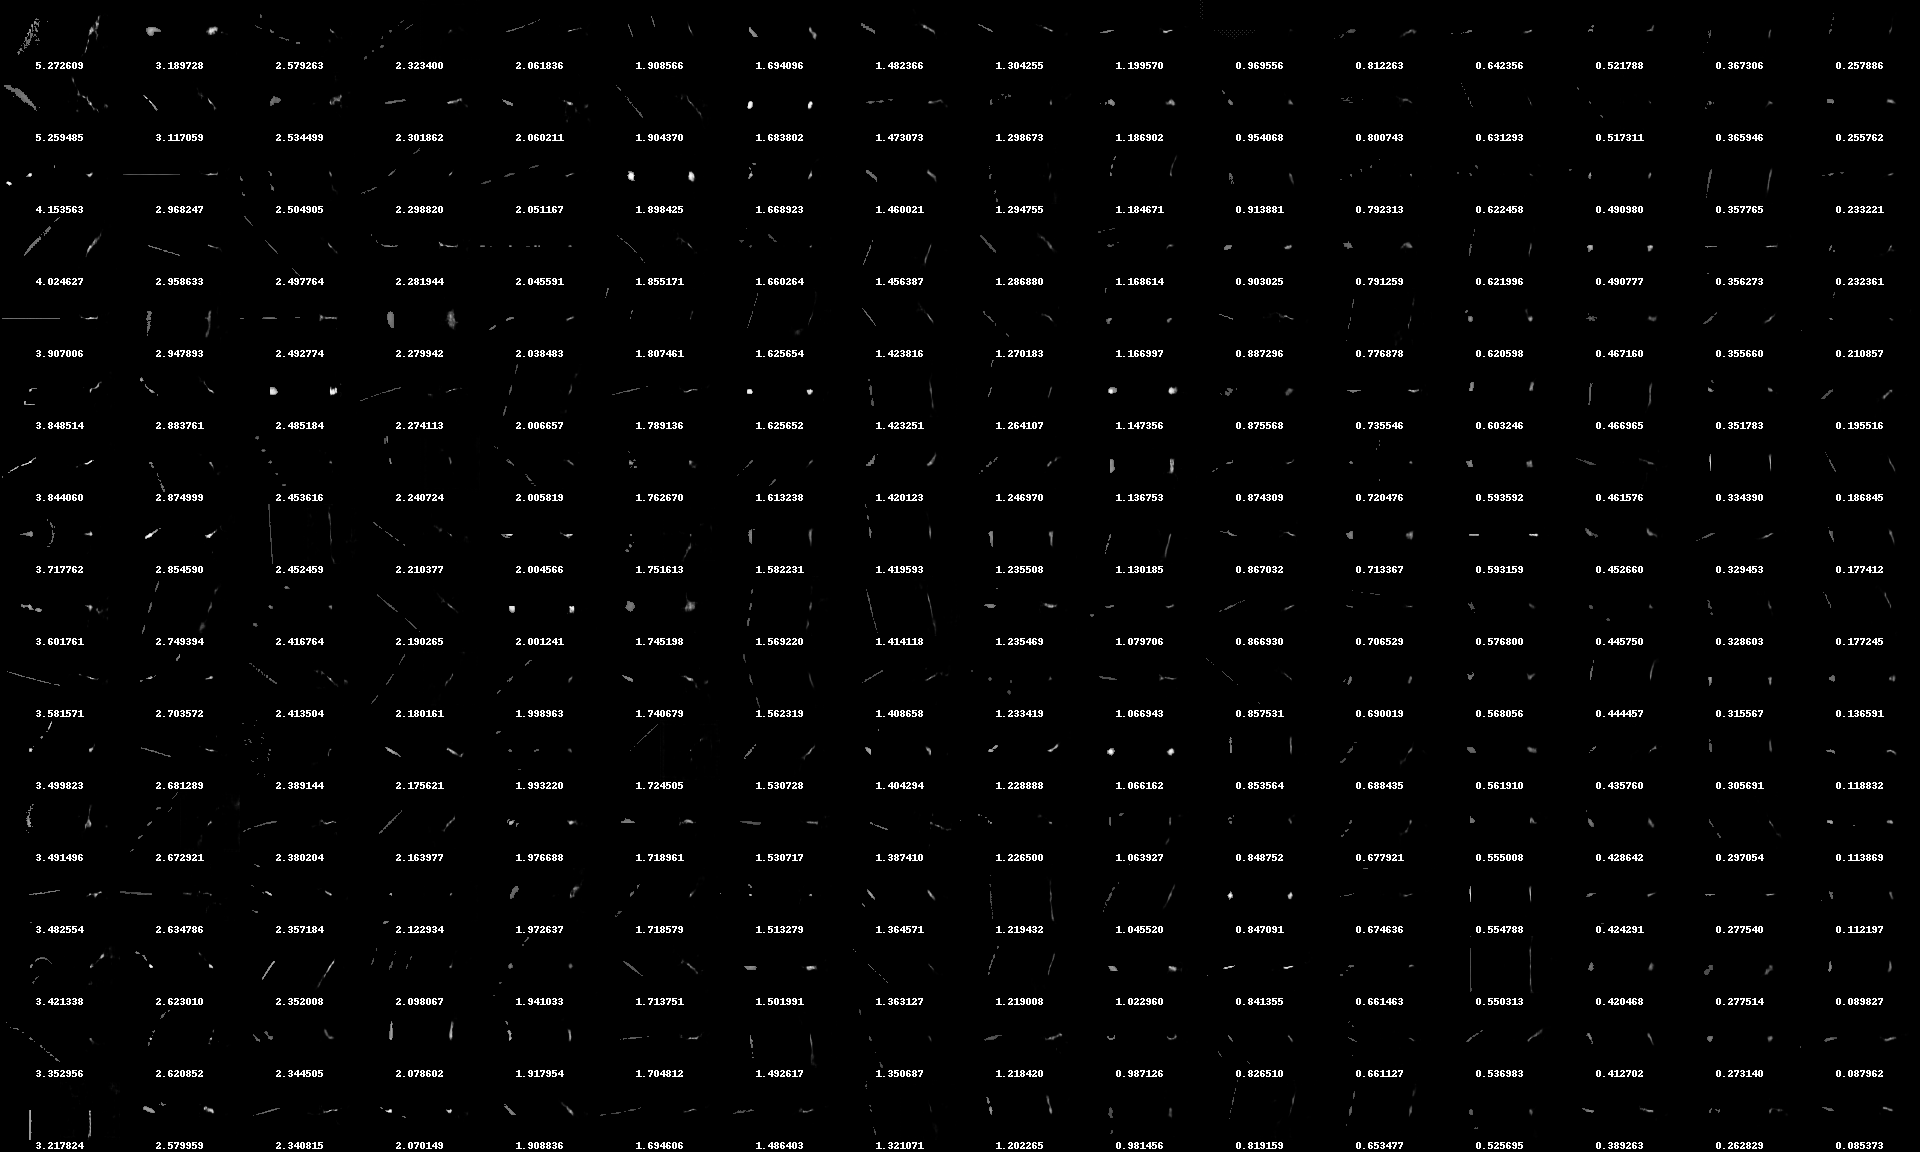

Kanał artifacts


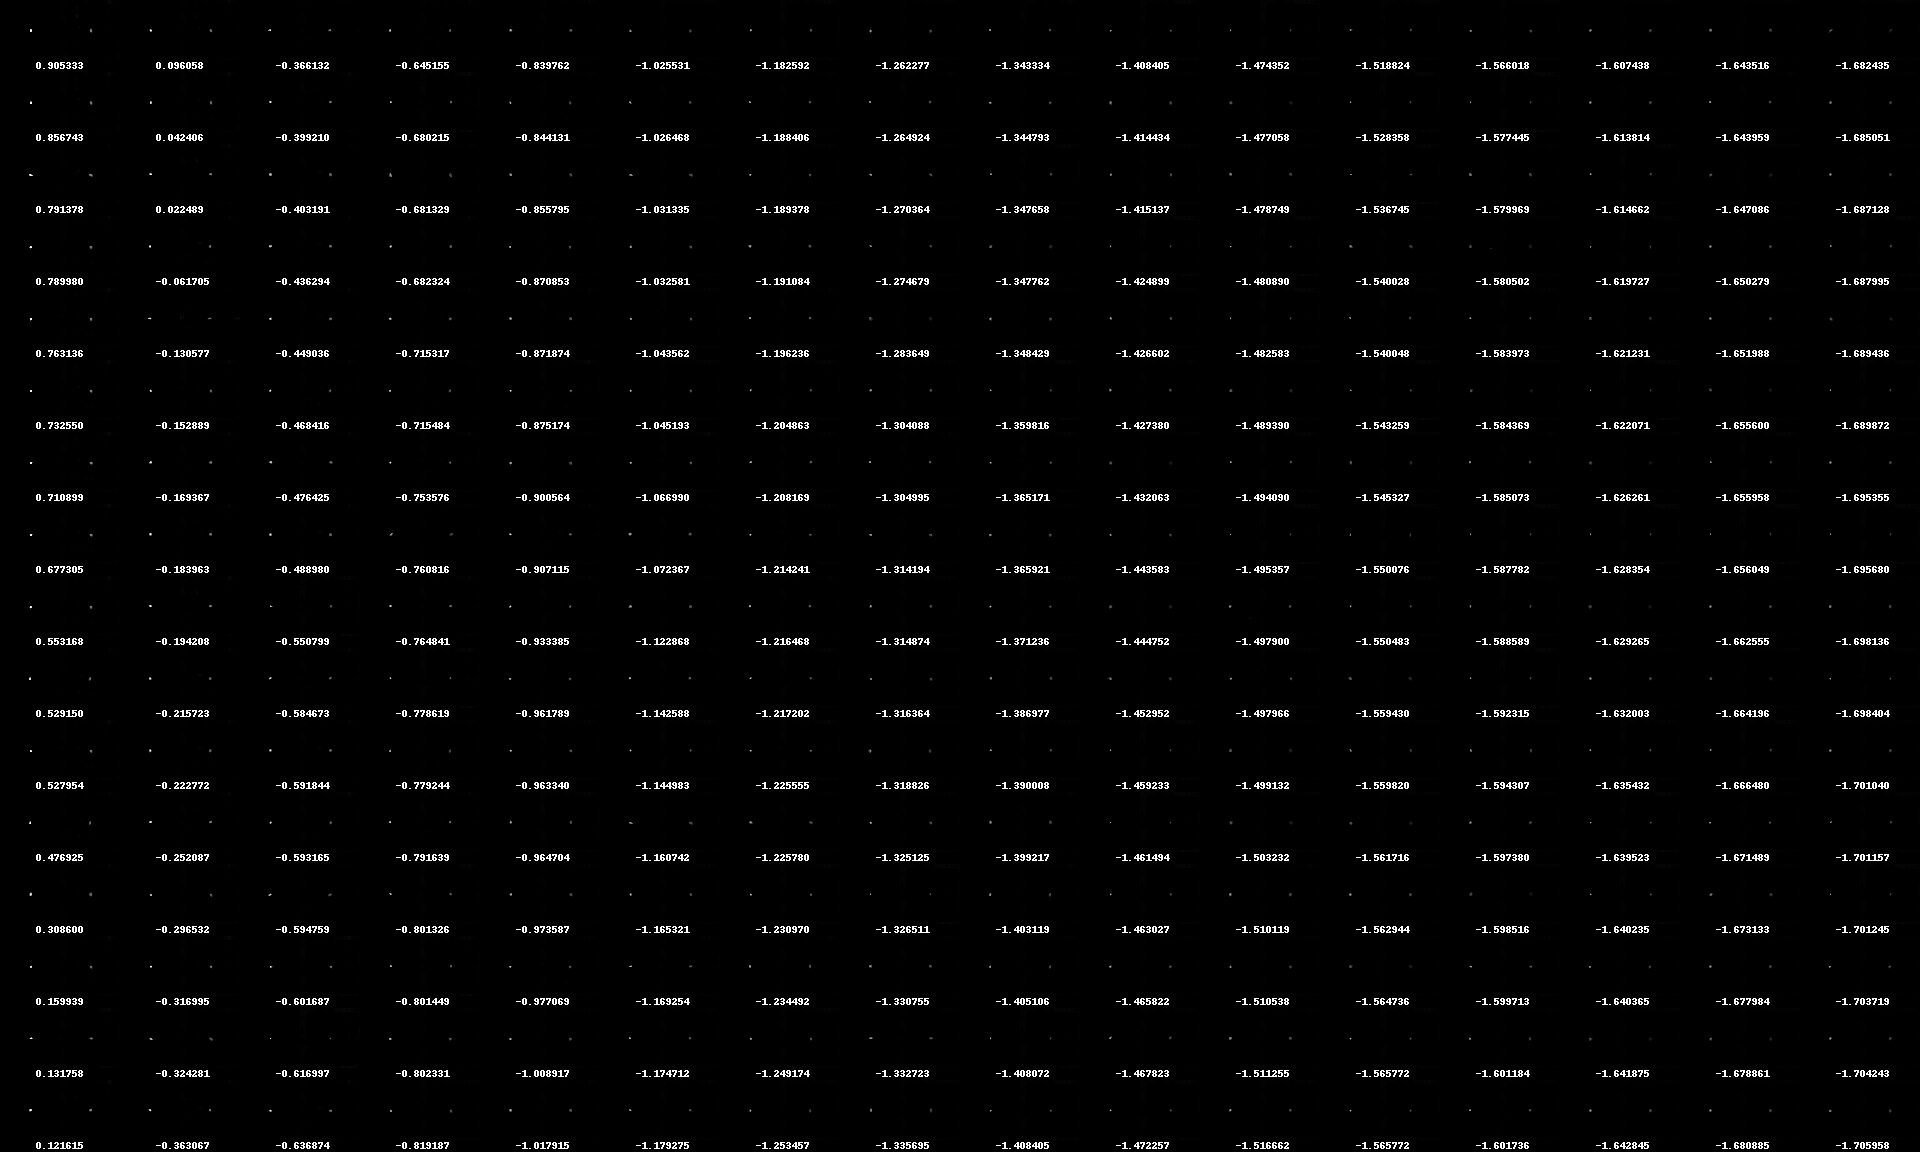

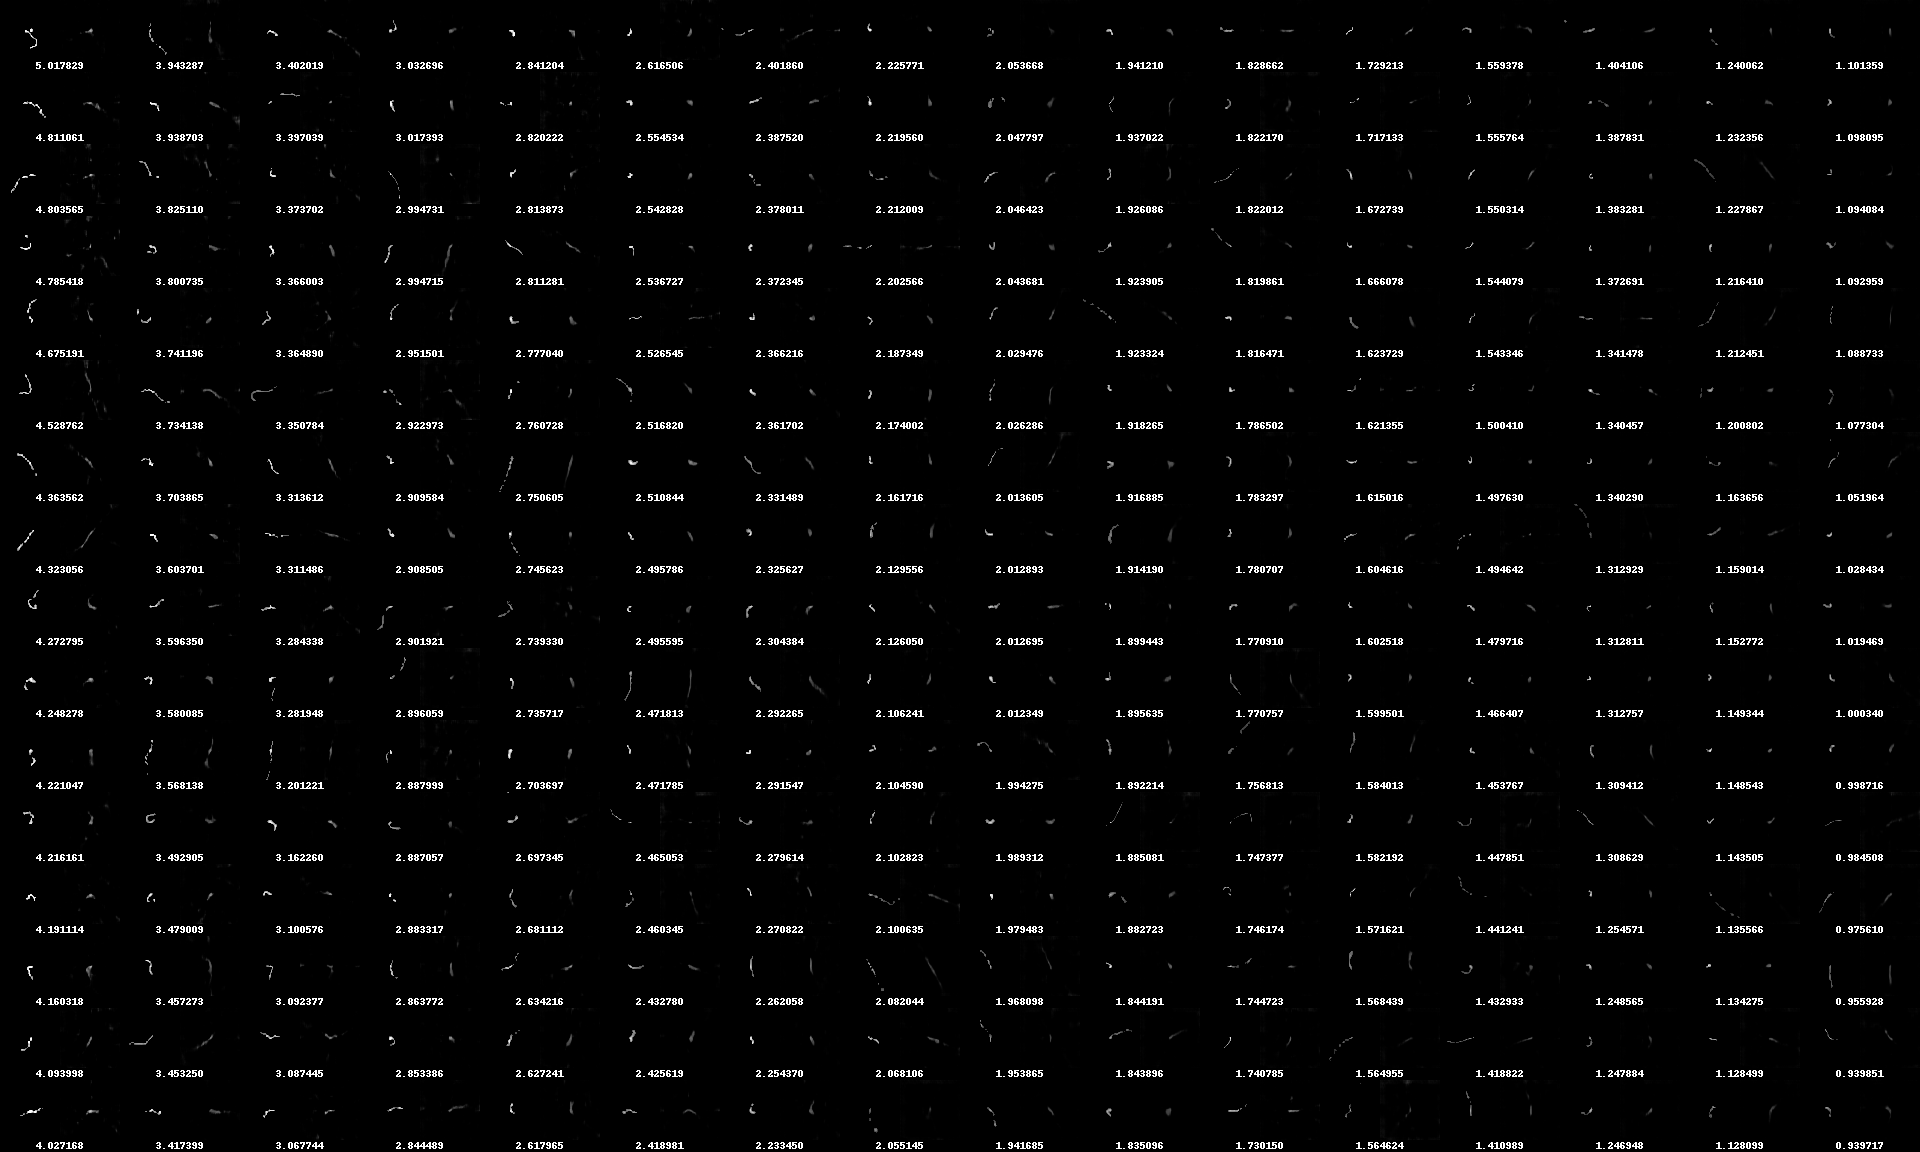

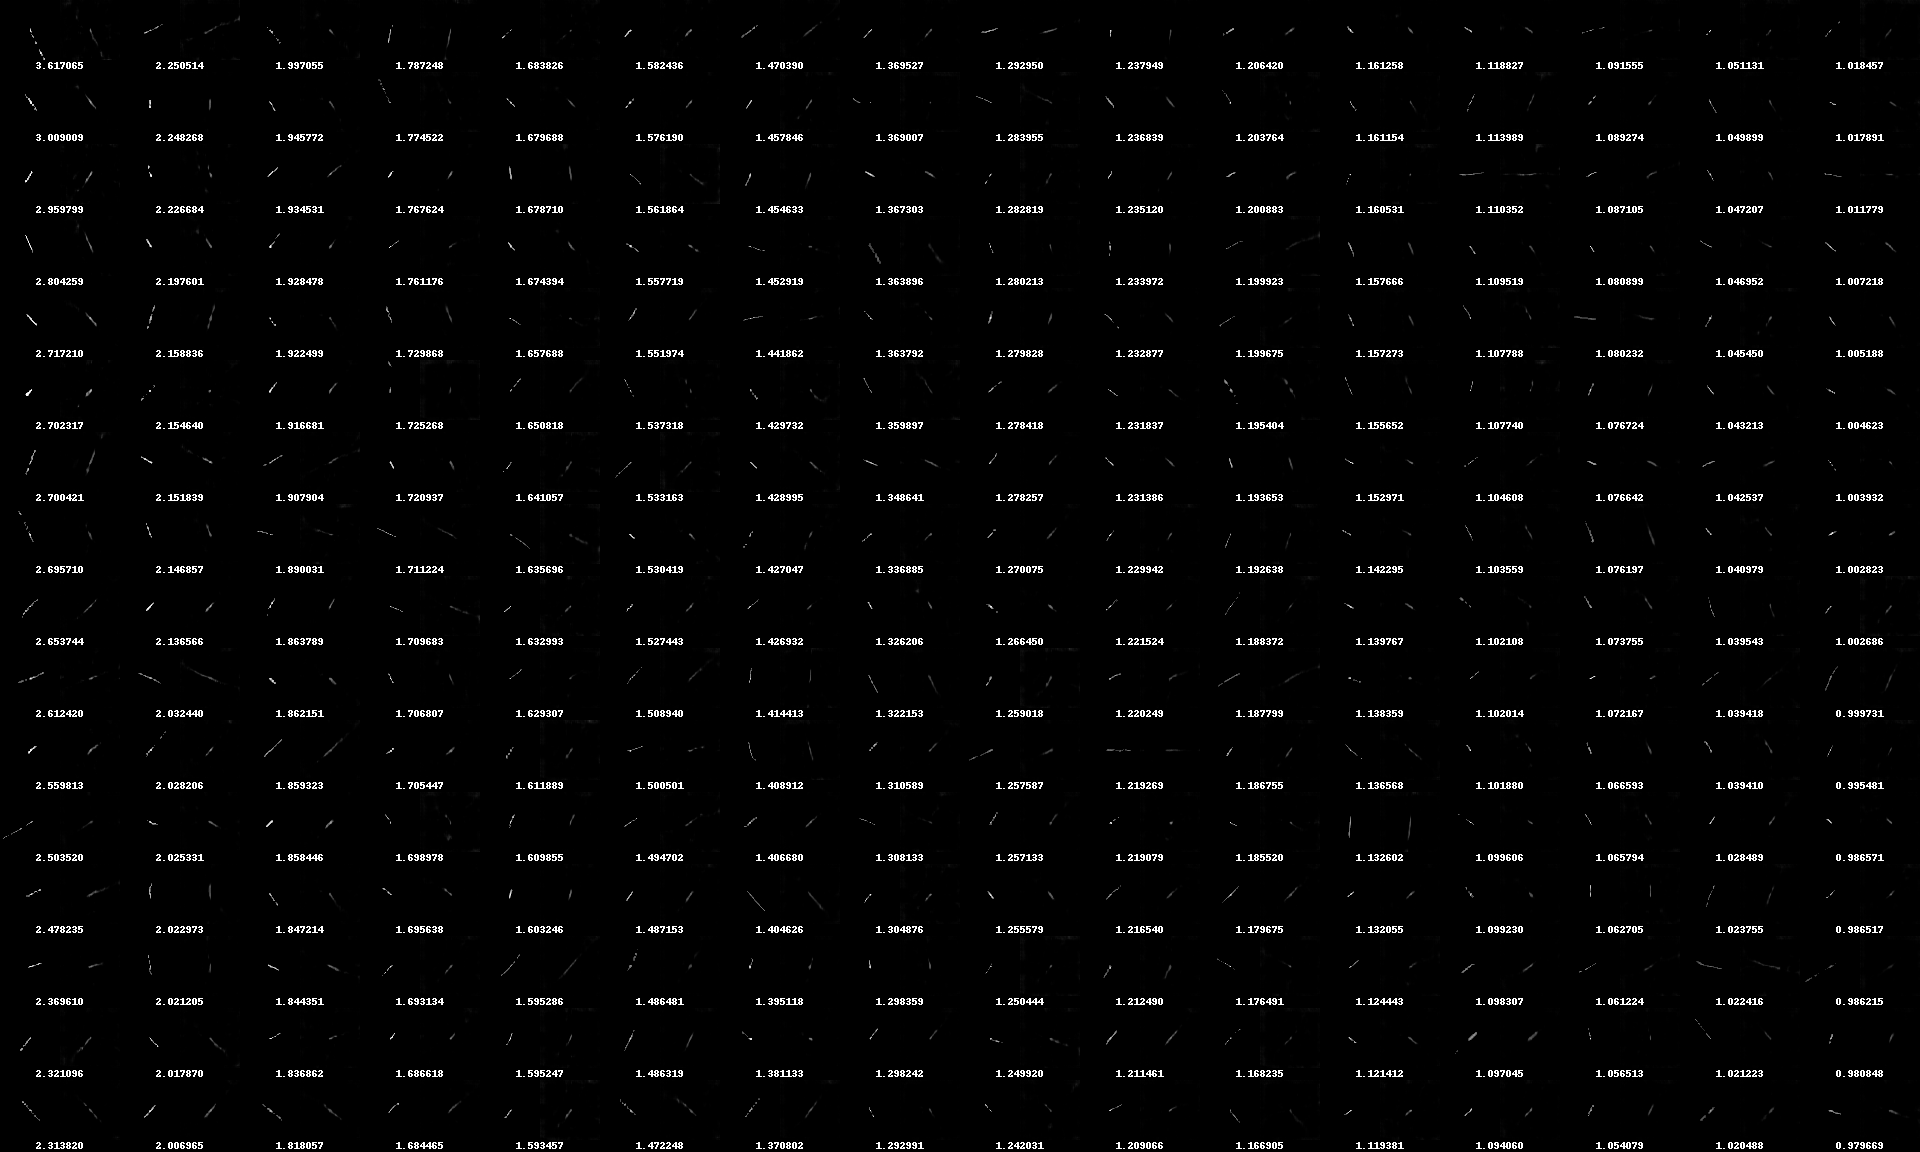

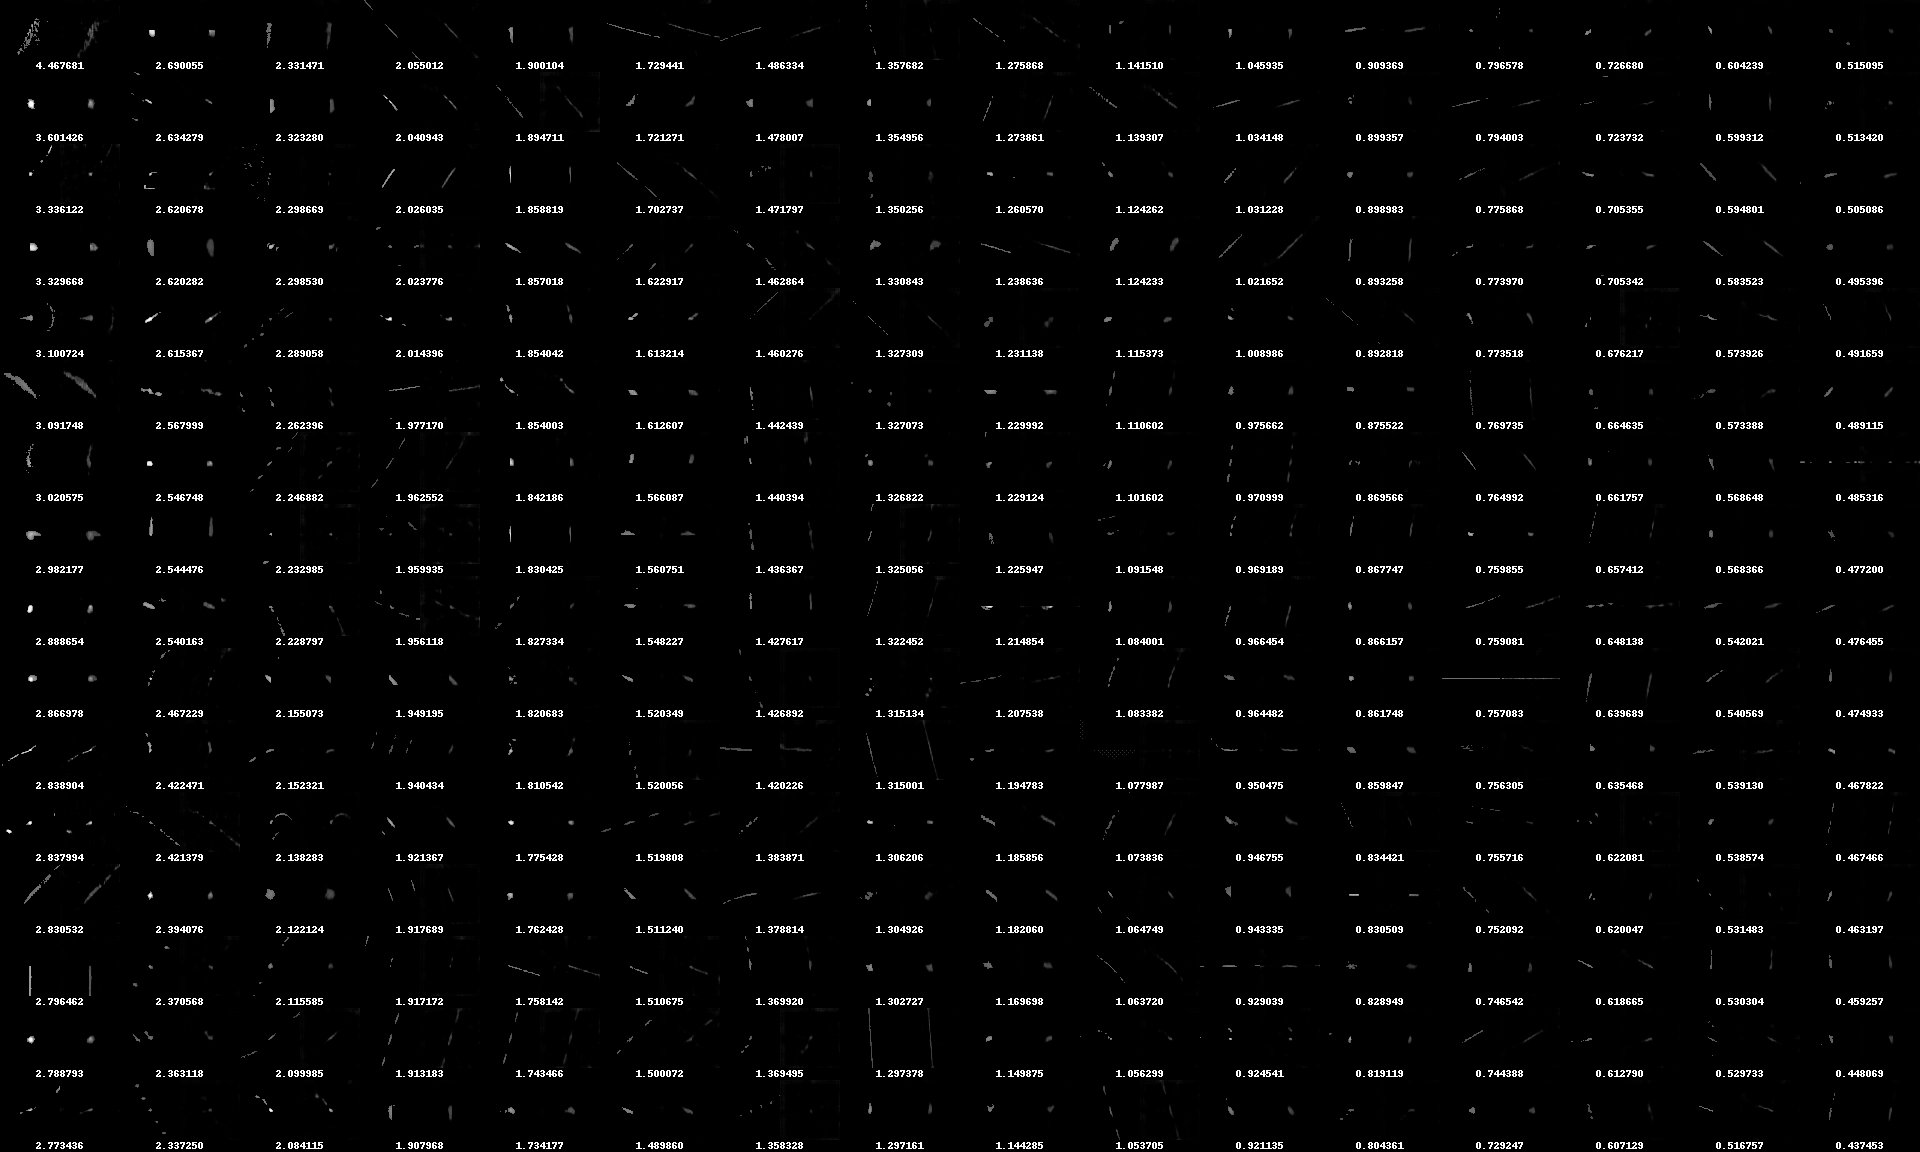

In [15]:
def imshow(vis):
    cv2.imwrite('tmp.png', vis)
    display(Image.open('tmp.png'))

def channel_reconstruction_preview(autoencoder):
    dots_reconstruction = autoencoder.predict(dots_set)
    worms_reconstruction = autoencoder.predict(worms_set)
    tracks_reconstruction = autoencoder.predict(tracks_set)
    artifacts_reconstruction = autoencoder.predict(artifacts_set)

    #fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

    imshow(visualize_predictions(dots_reconstruction, dots_set, dm_func_mean, False, 16)[0])
    imshow(visualize_predictions(worms_reconstruction, worms_set, dm_func_mean, False, 16)[0])
    imshow(visualize_predictions(tracks_reconstruction, tracks_set, dm_func_mean, False, 16)[0])
    imshow(visualize_predictions(artifacts_reconstruction, artifacts_set, dm_func_mean, False, 16)[0])

print('Kanał dots')
channel_reconstruction_preview(dots_autoencoder)

print('Kanał tracks')
channel_reconstruction_preview(tracks_autoencoder)

print('Kanał worms')
channel_reconstruction_preview(worms_autoencoder)

print('Kanał artifacts')
channel_reconstruction_preview(artifacts_autoencoder)